In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from IPython.display import Image

pal = sns.color_palette()
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


### Business / Policy Question
---

Migration is a high in the political and policy agenda. Can we predict the next migration wave?

### User
---

World Bank and policy makers of both countries of origin and destination

### Objective
---

__
Identify a predictive model migration fluxes, based on existing indicators produced or collected by the World Bank. 
__

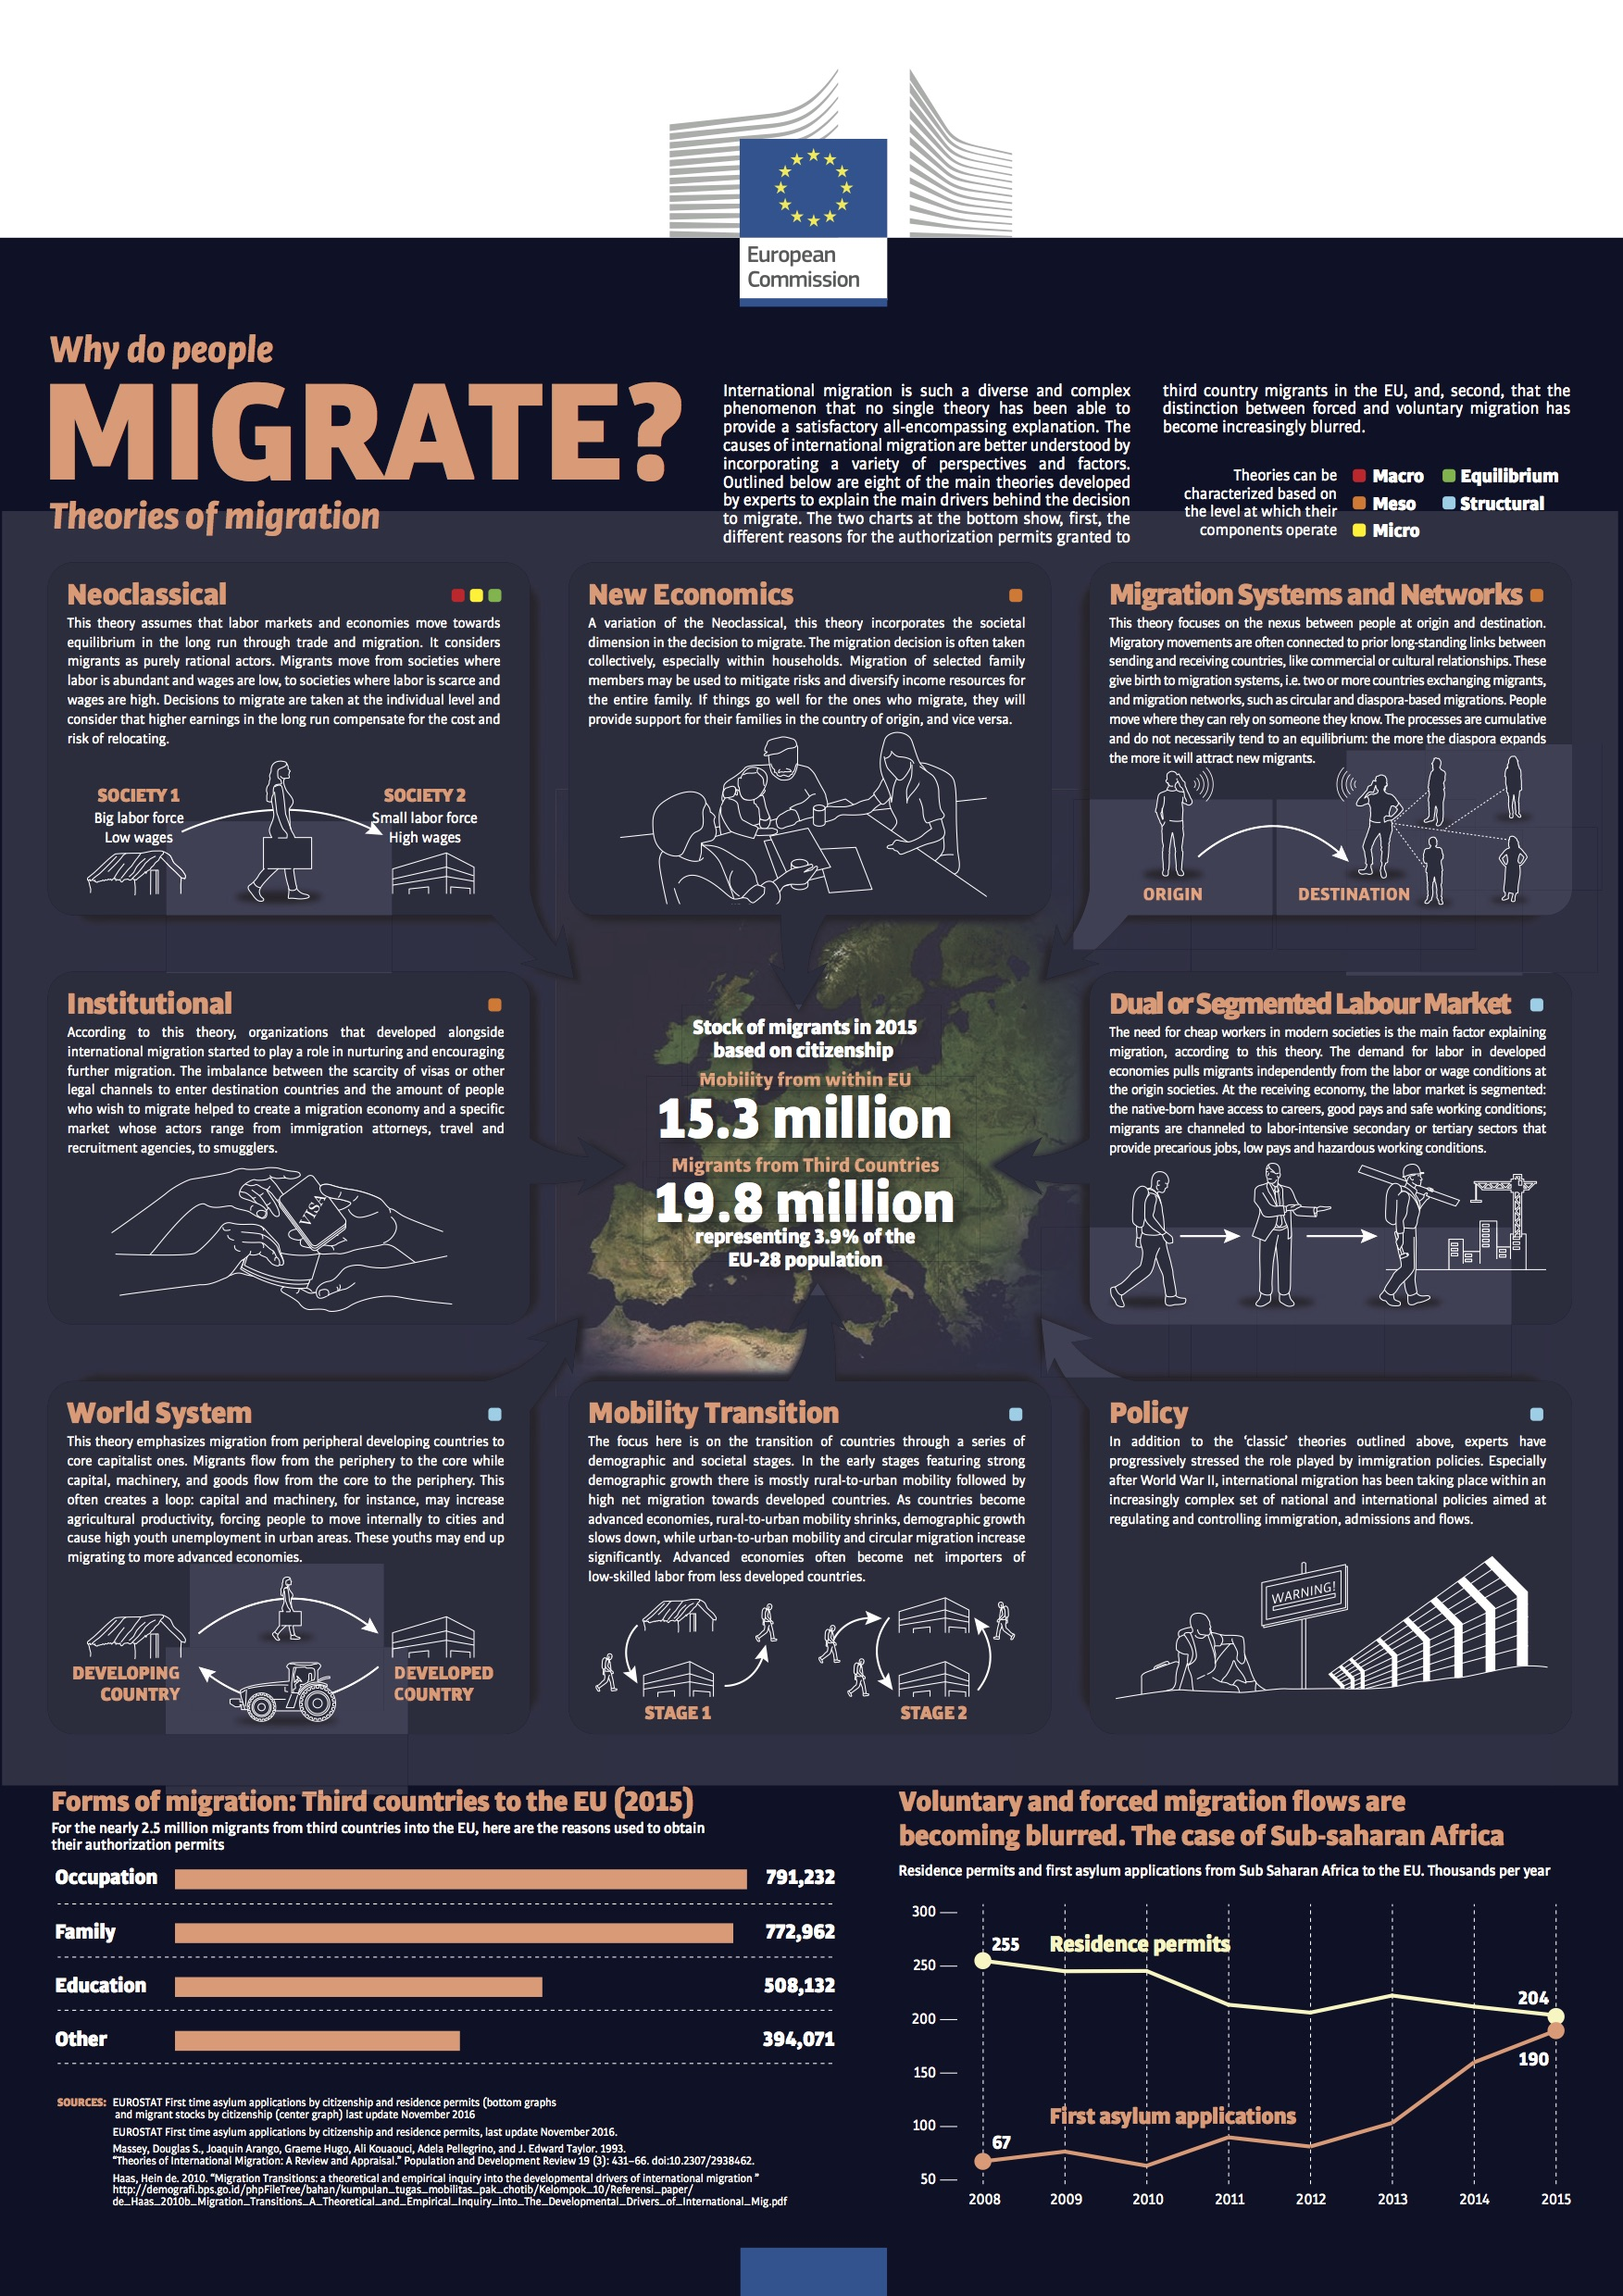

In [2]:
Image("figures/theoriesofmigration.jpg",width=1000)

### Data availability
___

Data are free and available at http://databank.worldbank.org/data/home.aspx

### Load and inspect data

In [3]:
# load migration data
df_migr_raw = pd.read_csv('data/migration_data.csv')

In [4]:
df_migr_raw.head()

Country Origin Name Country Origin Code Migration by Gender Name  \
0         Afghanistan                 AFG                   Female   
1         Afghanistan                 AFG                   Female   
2         Afghanistan                 AFG                   Female   
3         Afghanistan                 AFG                   Female   
4         Afghanistan                 AFG                   Female   

  Migration by Gender Code Country Dest Name Country Dest Code 1960 [1960]  \
0                      FEM       Afghanistan               AFG           0   
1                      FEM           Albania               ALB           0   
2                      FEM           Algeria               DZA          22   
3                      FEM    American Samoa               ASM           0   
4                      FEM           Andorra               AND           0   

  1970 [1970] 1980 [1980] 1990 [1990] 2000 [2000]  
0           0           0           0           0  
1           0           0           0           0  
2           8           6           5           4  
3           0           0           0           0  
4           0           0           2           3

The table presents migration flows in terms of number of people, by 
1. Country of Origin
2. Gender
3. Country of Destination
4. Decade, from 1960 to 2000

We now select the relevant columns, rename them, and rearrange the database. Specifically, we will move the decade columns as entry, such that each row is representative of a single observation.

In [5]:
df_migr = df_migr_raw[['Country Origin Code', 'Migration by Gender Code', 'Country Dest Code', 
             '1960 [1960]', '1970 [1970]', '1980 [1980]', '1990 [1990]','2000 [2000]']]
df_migr.columns=['Origin','Gender','Destination','1960','1970','1980','1990','2000']

In [6]:
# rearrange data
df_migr_m = df_migr.melt(id_vars=['Origin','Gender','Destination'],var_name='Year')
df_migr_m['Year'] = df_migr_m['Year'].astype('int64')

We focus on the total migration, i.e. at this stage we do not consider the gender issue.

In [7]:
df_migr_tot = df_migr_m[df_migr_m['Gender']=='TOT']
del df_migr_tot['Gender']

In [292]:
df_migr_tot.value = pd.to_numeric(df_migr_tot.value, errors='coerce')
df_migr_tot.head()

/Users/lraso/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Origin Destination  Year  value
462    AFG         AFG  1960    0.0
463    AFG         ALB  1960    0.0
464    AFG         DZA  1960   41.0
465    AFG         ASM  1960    0.0
466    AFG         AND  1960    0.0

### Emigration Data
We will first work on emigration data only. Therefore the bilateral migration database is aggregated on the Country of Origin and Year. 

In [293]:
emigration = df_migr_tot.groupby(['Origin','Year']).sum().reset_index()
emigration.columns = ['CountryCode', 'Year', 'Emigration, total']

In [294]:
emigration.head()

CountryCode  Year  Emigration, total
0         ABW  1960             1622.0
1         ABW  1970             1041.0
2         ABW  1980             4280.0
3         ABW  1990             9202.0
4         ABW  2000            10059.0

### World Bank Indicators

In [295]:
def select_years (df,  years, column_dates):
    """" Select the years from a larger datasests """

    df_out = pd.DataFrame()
    for year in years:
        df_year = df [df[column_dates]== year]
        df_out = df_out.append(df_year,ignore_index=True)
    return(df_out)    

In [296]:
# load data
df_indicators = pd.read_csv('data/indicators.csv')

In [297]:
# delete non-relevant information
del df_indicators['IndicatorCode']
df_indicators.columns = ['Country','CountryCode','Indicator','Year','Value']

In [298]:
# select relevant year#  
years_migration = df_migr_m['Year'].unique()
years_migr_int = [int(year) for year in years_migration]
df_indicators_years = select_years (df_indicators, years_migr_int ,'Year')
df_indicators_years.head()

Country CountryCode                                          Indicator  \
0  Arab World         ARB  Adolescent fertility rate (births per 1,000 wo...   
1  Arab World         ARB  Age dependency ratio (% of working-age populat...   
2  Arab World         ARB  Age dependency ratio, old (% of working-age po...   
3  Arab World         ARB  Age dependency ratio, young (% of working-age ...   
4  Arab World         ARB        Arms exports (SIPRI trend indicator values)   

   Year         Value  
0  1960  1.335609e+02  
1  1960  8.779760e+01  
2  1960  6.634579e+00  
3  1960  8.102333e+01  
4  1960  3.000000e+06

In [299]:
# reshape indicators
df_indicators_years_pivot = df_indicators_years.pivot_table(index=['CountryCode','Year'],columns='Indicator',values='Value')
df_indicators_years_pivot = df_indicators_years_pivot.reset_index()

#### Add region
The region to wich the country belongs can be a relevant feature in estimating emigration. This is contained in the "countries" table of the worldbank database, which must be imported and merged with the "indicators", table.

In [16]:
# load country data
df_country = pd.read_csv('data/countries.csv')
# select relevant columns
df_country = df_country[['CountryCode','Region']]
# merge with indicators data
df_indicators_years_pivot = df_indicators_years_pivot.merge(df_country,how='left',on=['CountryCode'])

### Merge migration and worldbank datasets

In [17]:
# merge data-sets
#df_indicators_years_pivot.CountryCode = df_indicators_years_pivot.CountryCode.astype(str)
#emigration.CountryCode = emigration.Origin.astype(str)
data_set = pd.merge(df_indicators_years_pivot,emigration,on=['CountryCode','Year'])


In [18]:
# add relative Emigration
data_set['Emigration, % pop'] = data_set['Emigration, total']/data_set['Population, total']*100

### Exploratory Data Analysis

#### Emigration over time

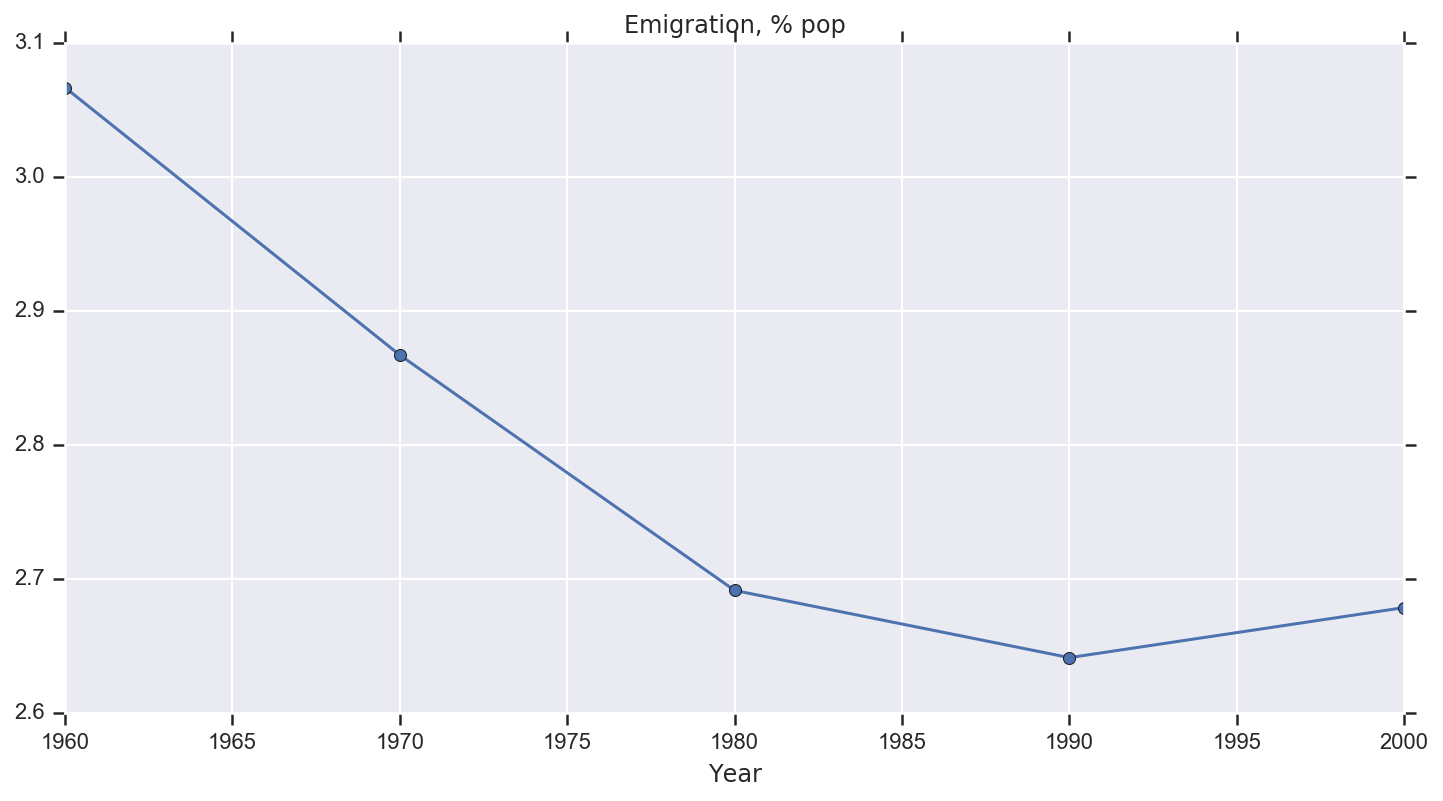

In [344]:
world_emigr_year = data_set.groupby(['Year']).sum()[['Emigration, total','Population, total']]
world_emigr_year['Emigration, % pop'] = emigr_year['Emigration, total']/emigr_year['Population, total']*100
world_emigr_year['Emigration, % pop'].plot(marker='o',title='Emigration, % pop')

______
The plot above shows the emigration / population ration per decade. It shows a less clear trend than the data about absolute emigration. Nonetheless, emigration has increased since 1980 of more than 30 %.

#### Emigration by region, over time

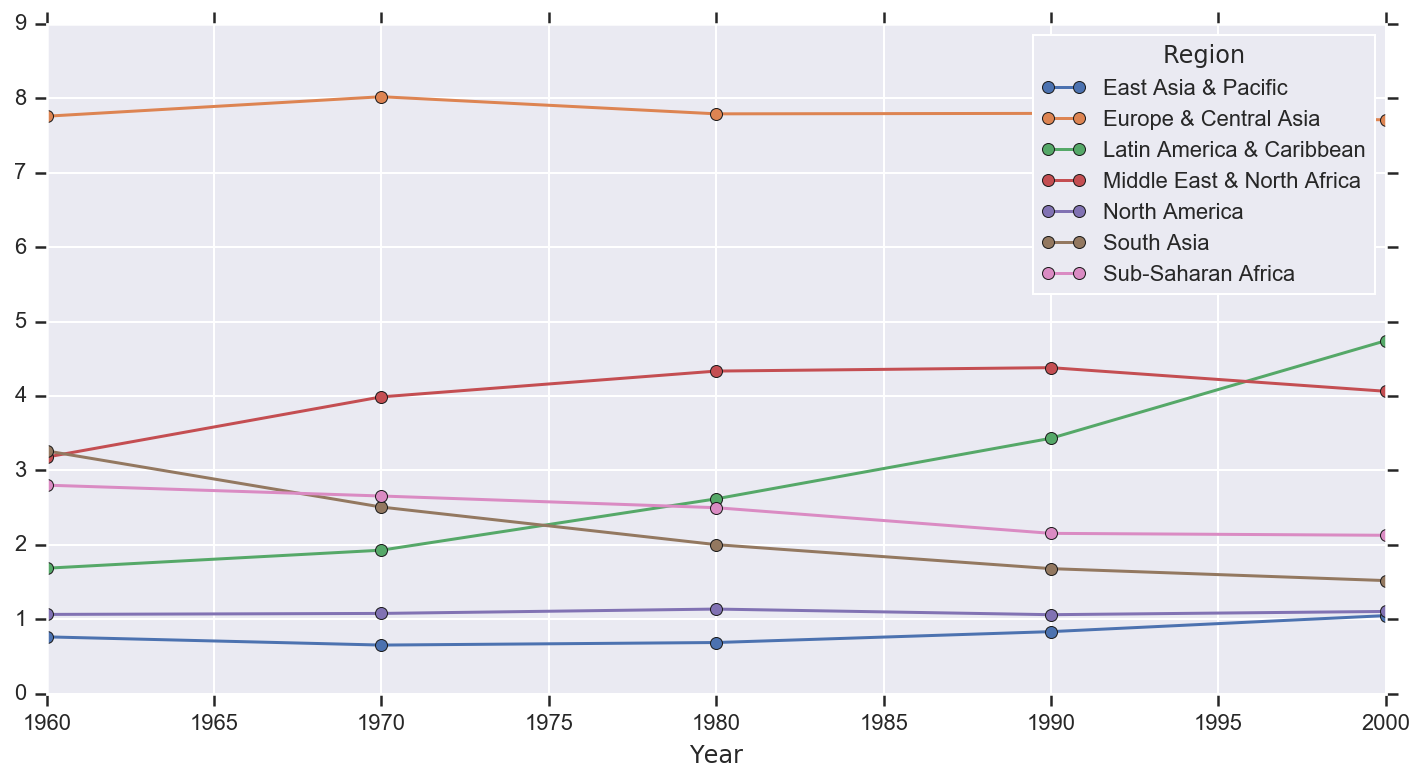

In [352]:
regions_emigr_year = data_set.groupby(['Year','Region']).sum()[['Emigration, total','Population, total']]
regions_emigr_year['Emigration, % pop'] = regions_emigr_year['Emigration, total']/regions_emigr_year['Population, total']*100
#data_set.pivot_table(columns='Region',index='Year',values='Emigration, % pop').plot(marker='o',title='Emigration, % pop')
regions_emigr_year = regions_emigr_year.pivot_table(columns='Region',index='Year',values='Emigration, % pop' )
regions_emigr_year.plot(marker='o')

_____
We can zoom on these region if the process is dominated by some countries, or if it is a process at the regional level  

#### Emigration vs Population and GDP
Clearly, more people, more emigration. All economic theories stresses the importance of the economic factor. 

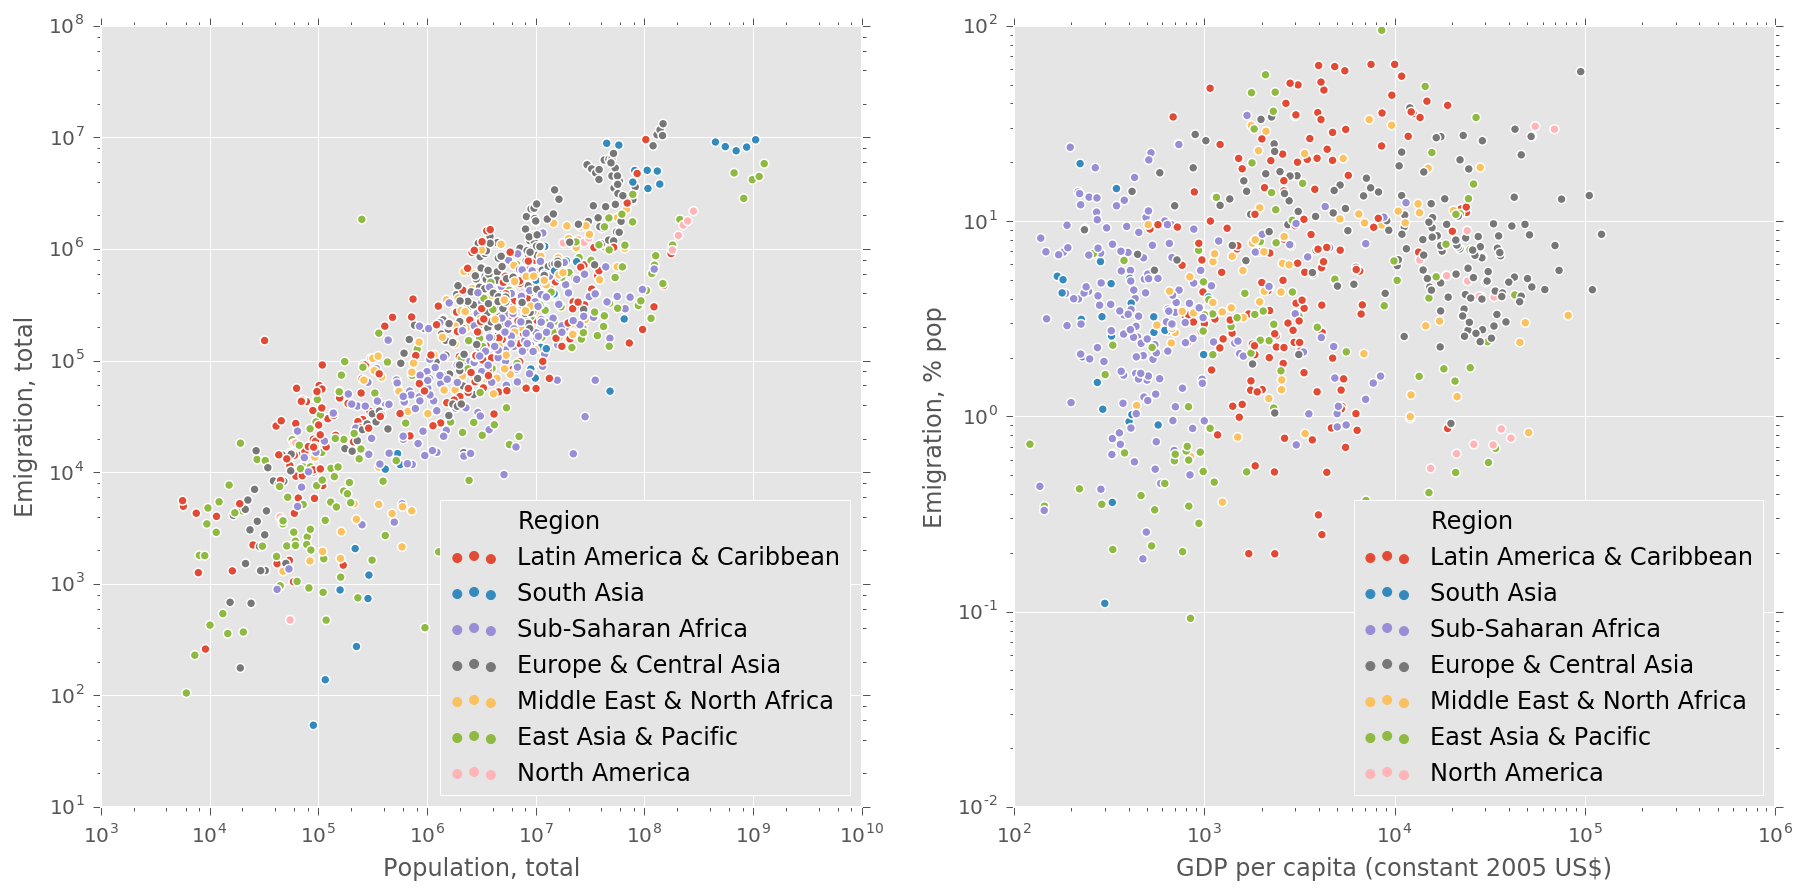

In [24]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plot1 = sns.scatterplot(data=data_set,y='Emigration, total',x='Population, total',hue='Region' )
plot1.set_xscale('log')
plot1.set_yscale('log')
plt.legend(loc='lower right')

plt.subplot(122)
plot1 = sns.scatterplot(data=data_set,y='Emigration, % pop',x='GDP per capita (constant 2005 US$)',hue='Region' )
plot1.set_xscale('log')
plot1.set_yscale('log')
plt.legend(loc='lower right')

____
The larger the country, the larger the emigration. Intuitive. Still countries of same dimension 1-2 orders of magnitude of difference in emigration. See also the general increase of emigration over the year. Let's also see the difference by Region

Middle level countries have a larger share of emigration. Economic conditions, however, explain only partially the migration process. It looks that poorest countries (GDP per capita less than 2000 suffer of a "poverty-trap" effect.

The division by region shows that 

### Cleaning datasets
The World Bank indicators dataset is not ready-to-use. It contains an very large number of missing data. 

In [359]:
data_set.isnull().sum()
print('The null values are ' + str(data_set.shape) + ' for indicators and country, respectively')

The null values are (1015, 1144) for indicators and country, respectively


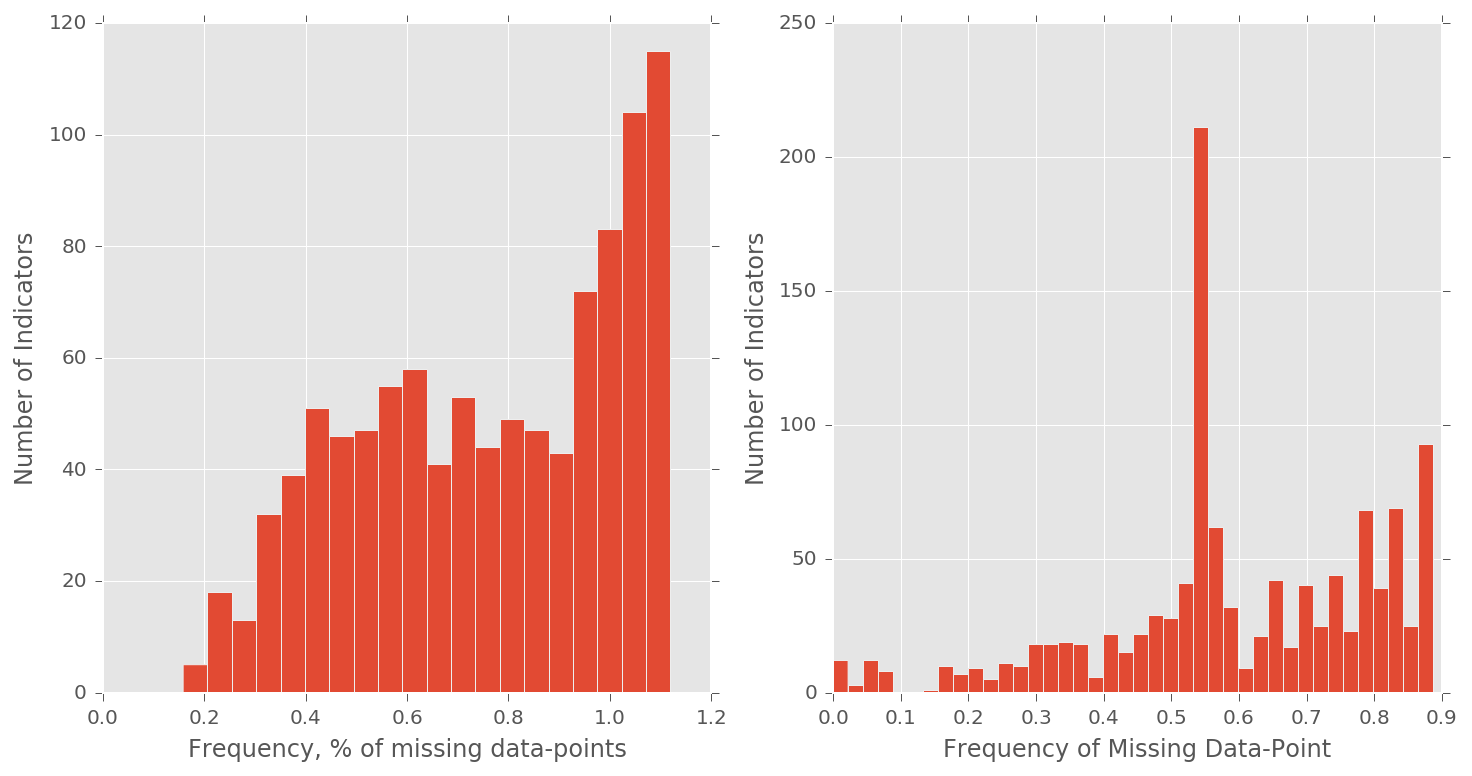

In [29]:
# statistics on missing data
plt.subplot(121)
plt.hist(data_set.isnull().sum(1).values/data_set.shape[0],bins=20)
plt.ylabel('Number of Indicators')
plt.xlabel('Frequency, % of missing data-points')
plt.subplot(122)
plt.hist(data_set.isnull().sum()/data_set.shape[1],bins=40)
plt.xlabel('Frequency of Missing Data-Point')
plt.ylabel('Number of Indicators')

There are data-points that are poorly populated. These should also be removed.

The function smart_cut drops rows and columns with a large number of missing data, until a small percentage of missing value, considered acceptable is reached. The wheight modulates the importance of keeping columns. Since we prefer to have more datapoints than indicators, we will set this parameter at a value lower than 1 (more weights to data-points) 

In [32]:
from migration import smart_cut, order_by_nan,sel_regressor    

threshold = 0.10
weight_ind = 0.1
data_set_cut = smart_cut(data_set,threshold,weight_ind)

In [365]:
print('\n \n Using these parameters, we keep ' + str(data_set_cut.shape[0]) + ' datapoints and '+ 
      str(data_set_cut.shape[1]-2) + ' indicators \n')


 
 Using these parameters, we keep 794 datapoints and 97 indicators 



Below the retained indicators, and the number of missing values.

We now fill the remaining missing data with the average of its columns. There are probably better way to do this, but we will explore them in a second stage. 

In [35]:
data_set_cut = data_set_cut.fillna(data_set_cut.median())

Delete of LCU, Local current unit. Make little sense. 


In [36]:
containts_LCU = [s for s in data_set_cut.columns if 'LCU' in s]
data_set_cut = data_set_cut.drop(containts_LCU, axis=1)

We now have a clean usable dataset.

### Feature Engineering

##### Work on the log()
As seen in plots above, it makes more sense to work on the log transform. This is true for most of the indicators, including the target variable. See plot below. 

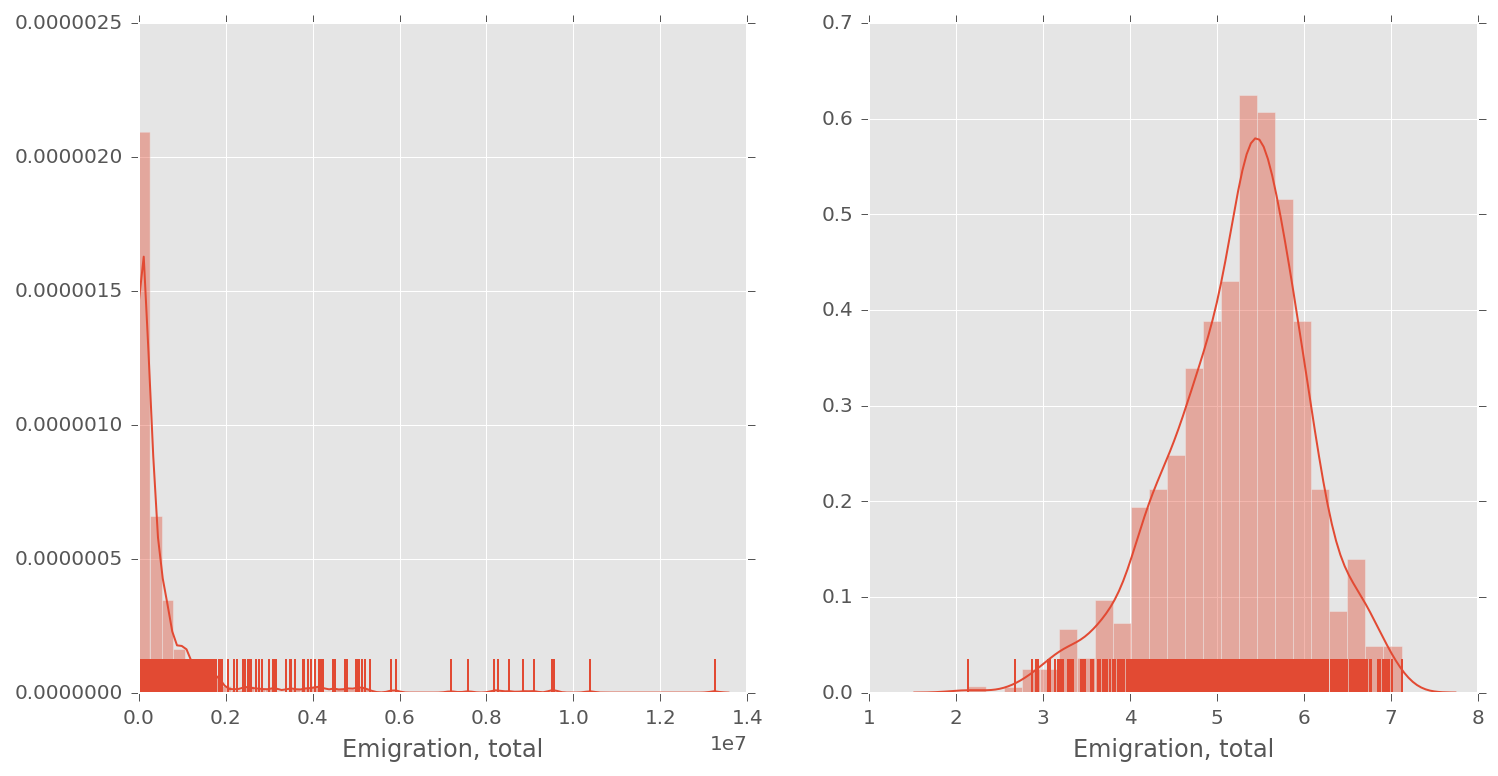

In [45]:
plt.subplot(121)
sns.distplot(data_set_cut['Emigration, total'],rug=True)
plt.xlim(0)
plt.subplot(122)
sns.distplot(np.log10(data_set_cut['Emigration, total']),rug=True)

Much skewed distribution. A model using these data would be dominated by the few extreme values. We transform the data, log ()

Much better shaped distribution. 

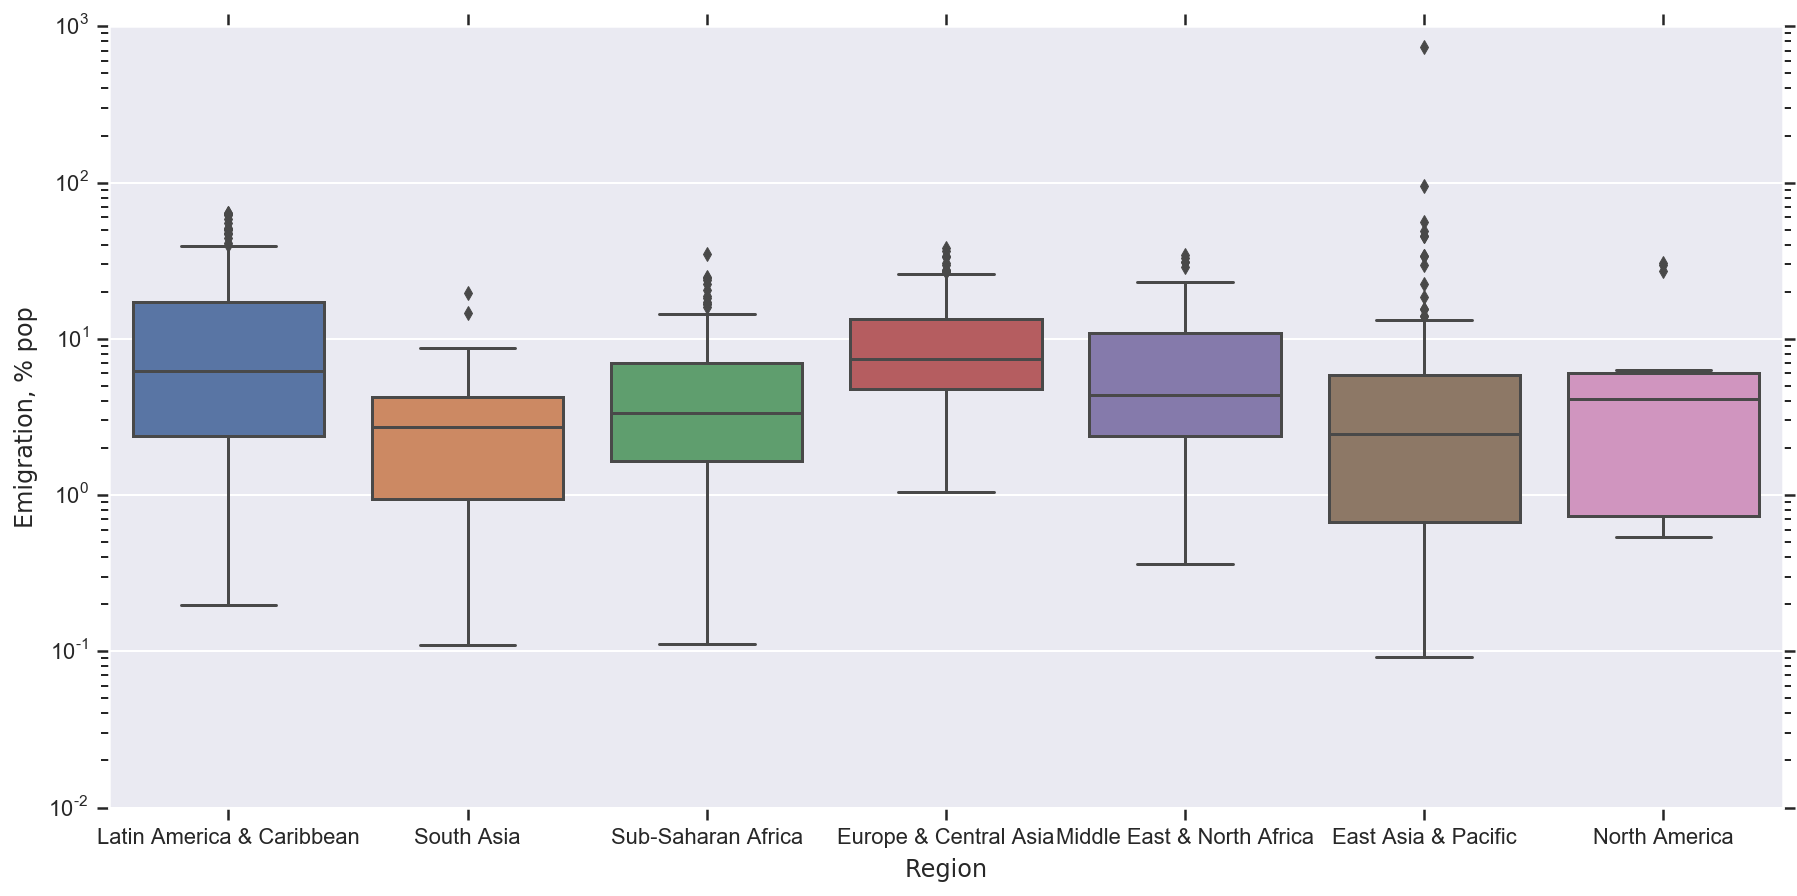

In [430]:
plt.figure(figsize=(15,7))
plot1 = sns.boxplot(data=data_set_cut,x='Region',y='Emigration, % pop')
plot1.set_yscale('log')


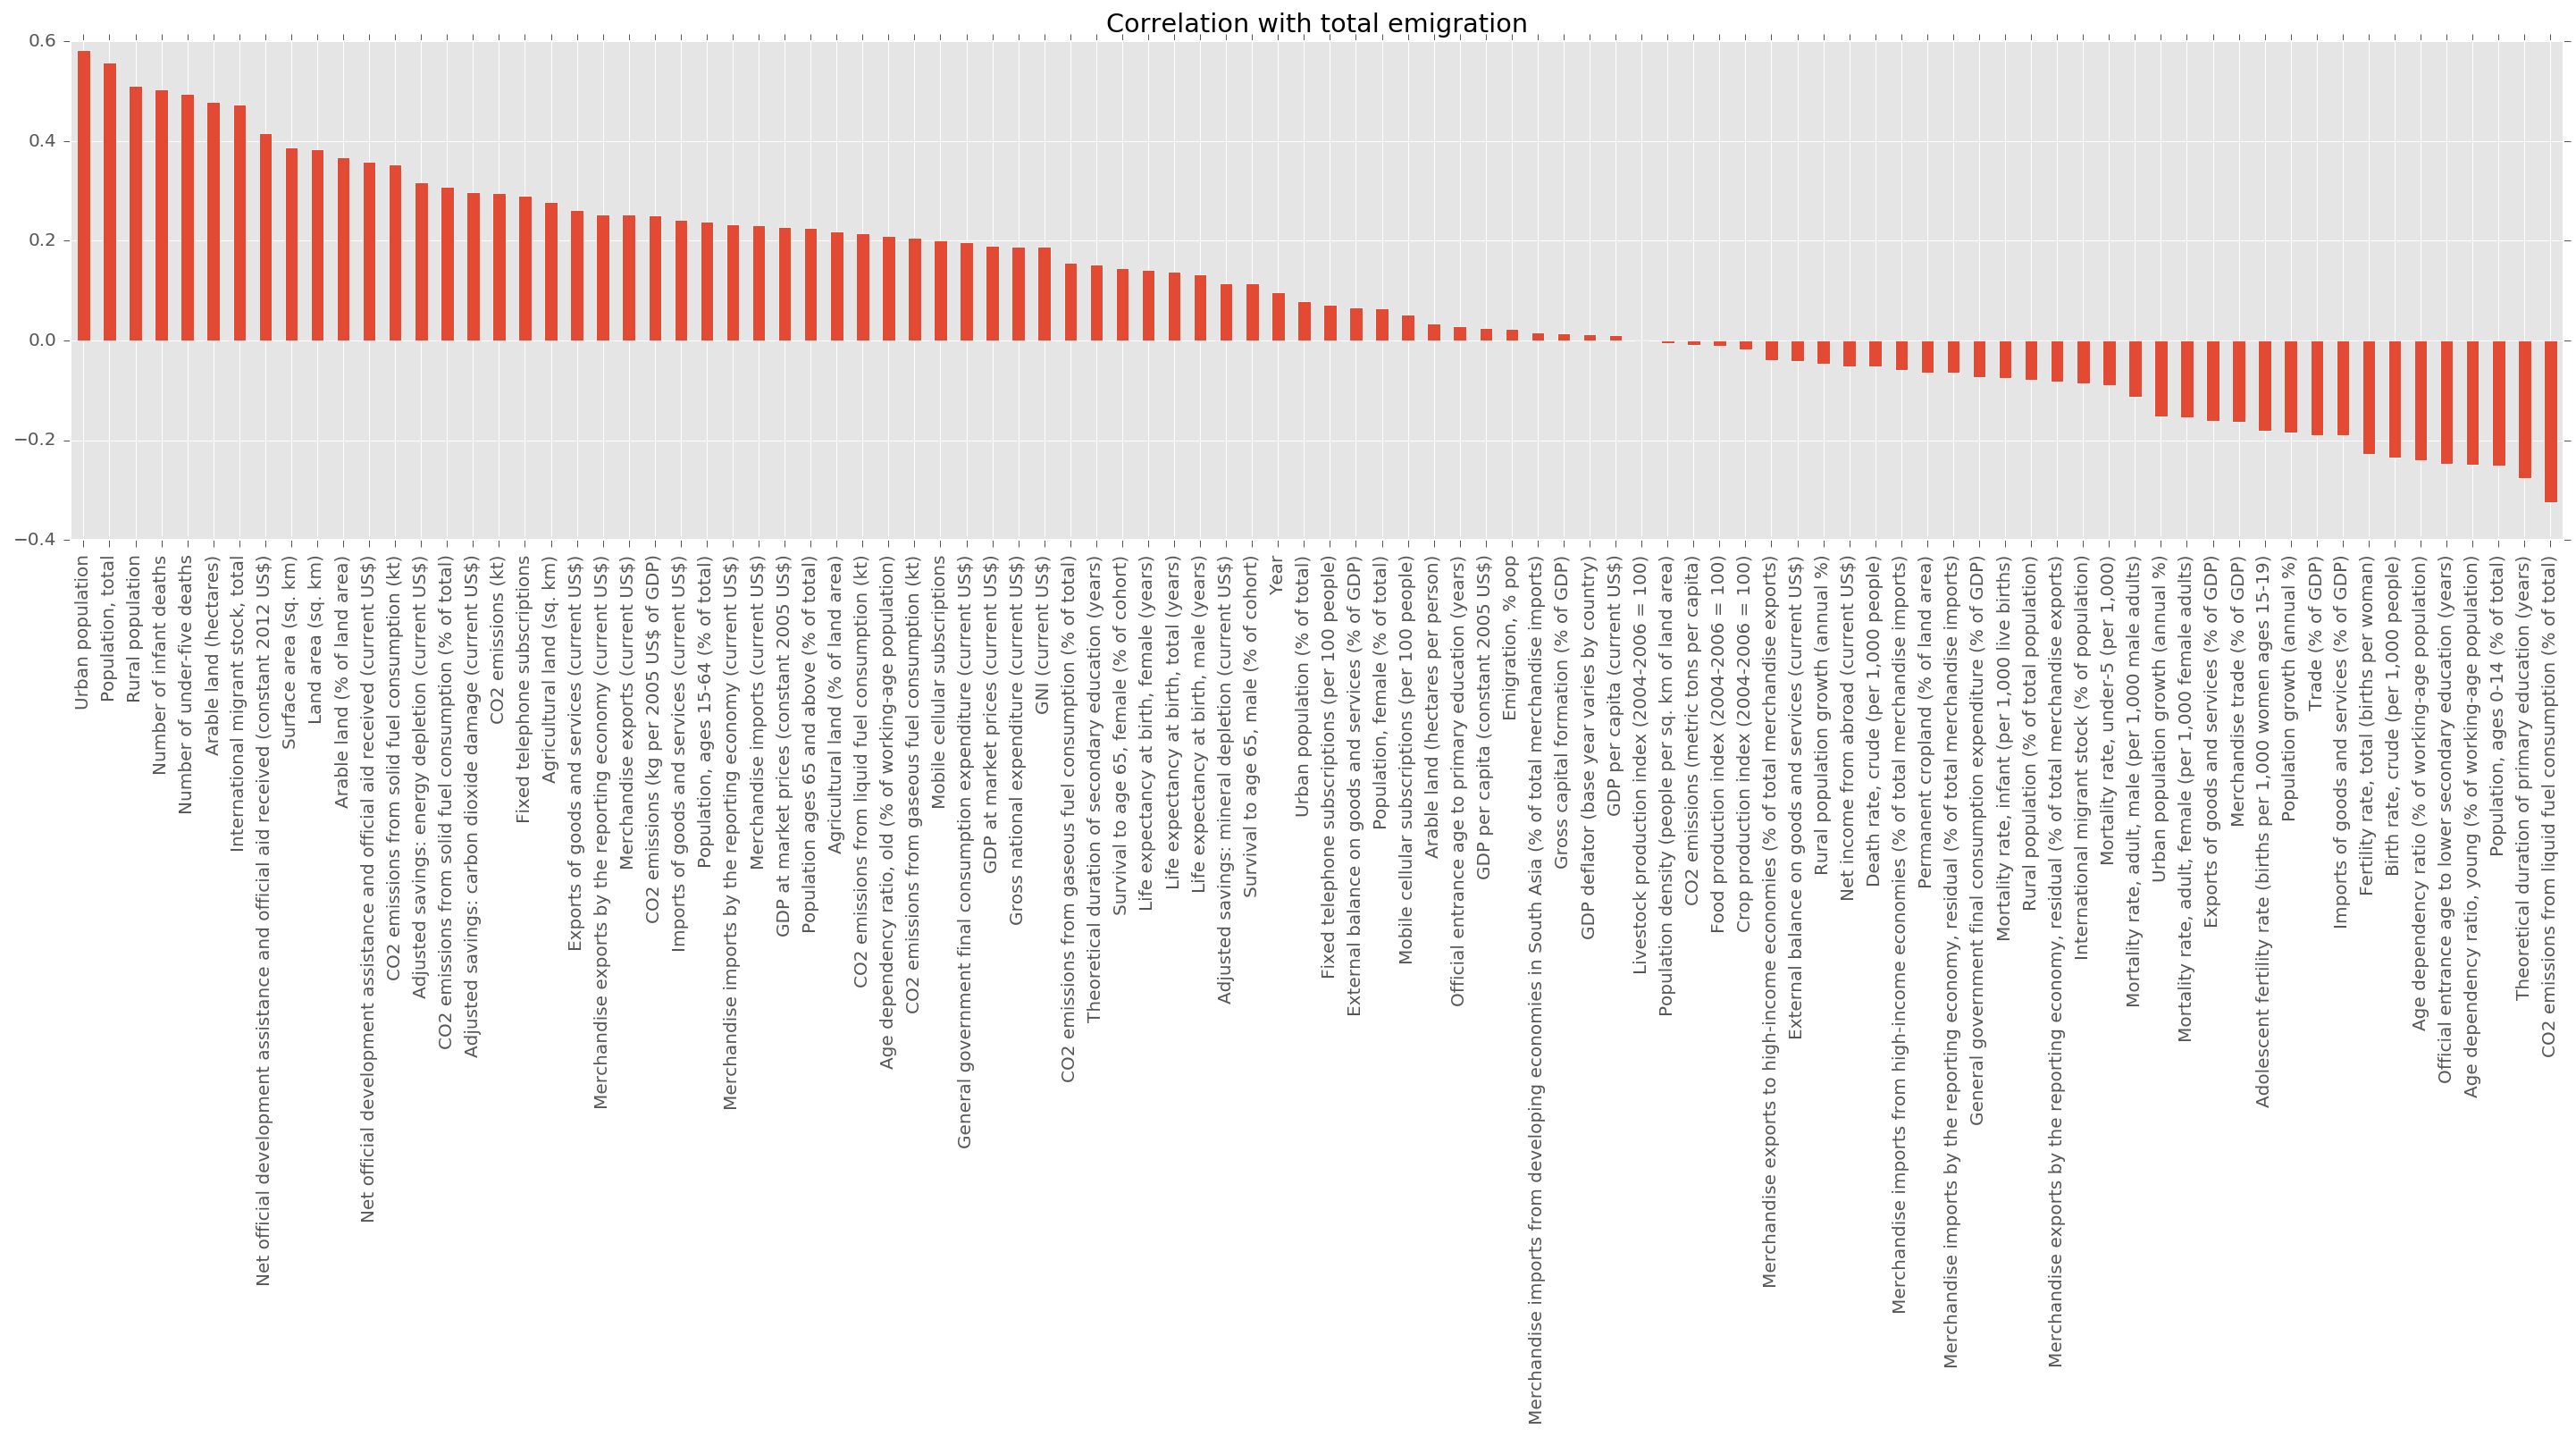

In [39]:

data_set_cut.corr()['Emigration, total'].drop('Emigration, total').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with total emigration')


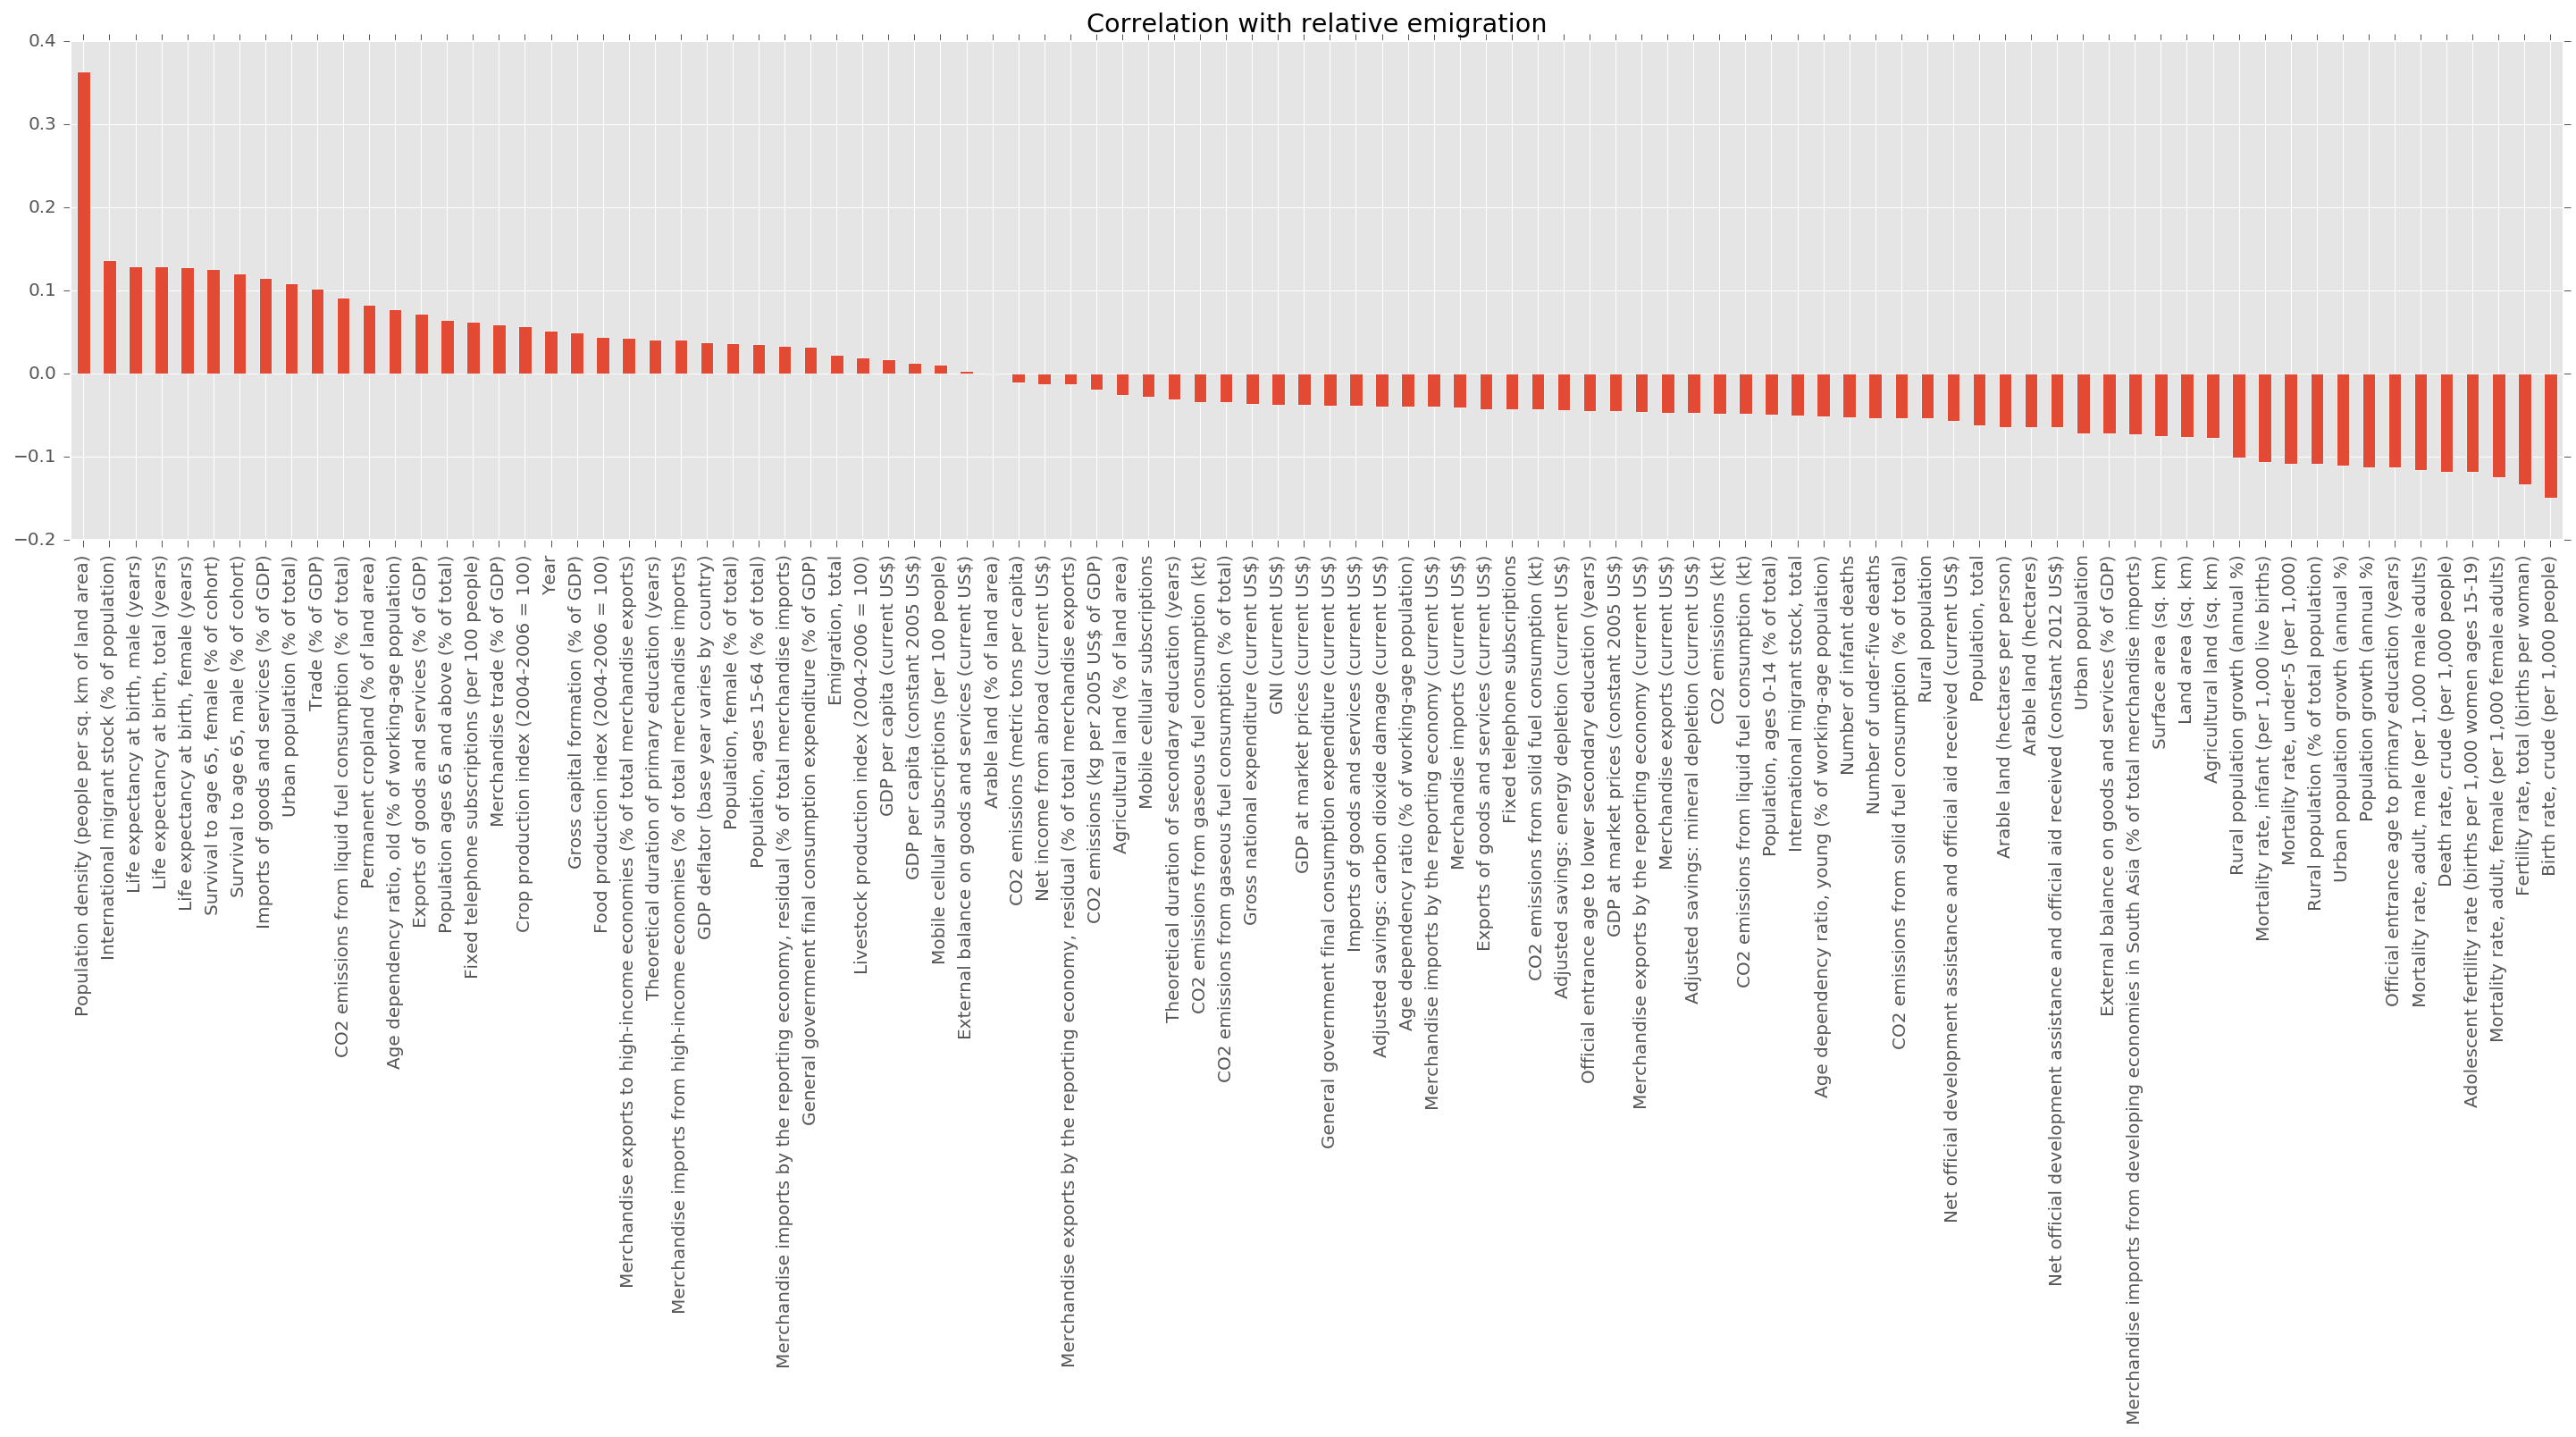

In [46]:
data_set_cut.corr()['Emigration, % pop'].drop('Emigration, % pop').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with relative emigration')

[]

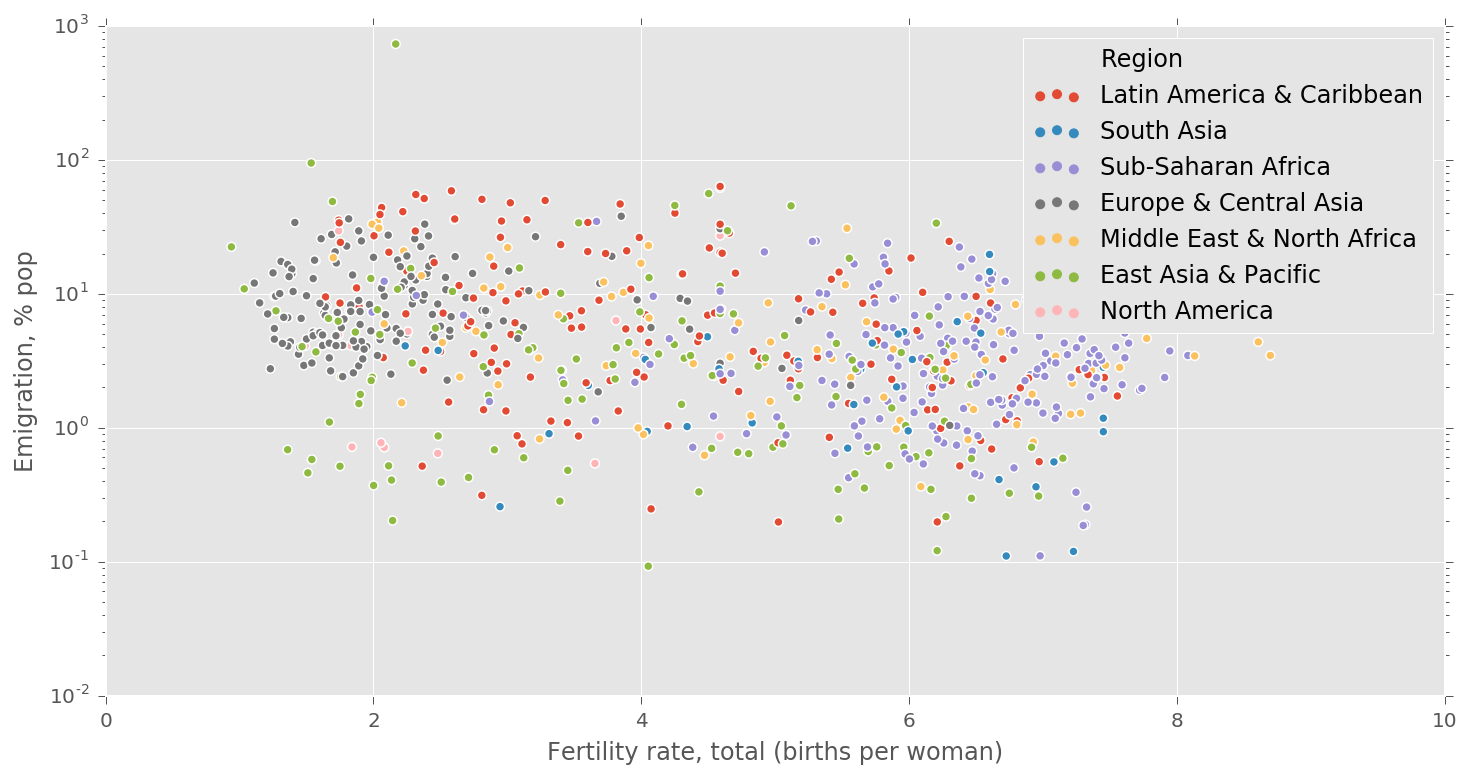

In [42]:
sns.scatterplot(data=data_set_cut,y='Emigration, % pop',x='Fertility rate, total (births per woman)',hue='Region').semilogy()#,hue='Region')

Presence of a weak negative signal, seems not depending on region. 

Meaning for feature engineering: do not use log, but the original indicator. We will keep both and leave the feature selection to the algorithm. 

In [55]:
data = data_set_cut.drop(['CountryCode','Region'],axis=1)

data_log = pd.DataFrame()
for column in data:
    if all(data[column]>0):
        data_log['Log of '+column] = data[column].apply(np.log10)
   

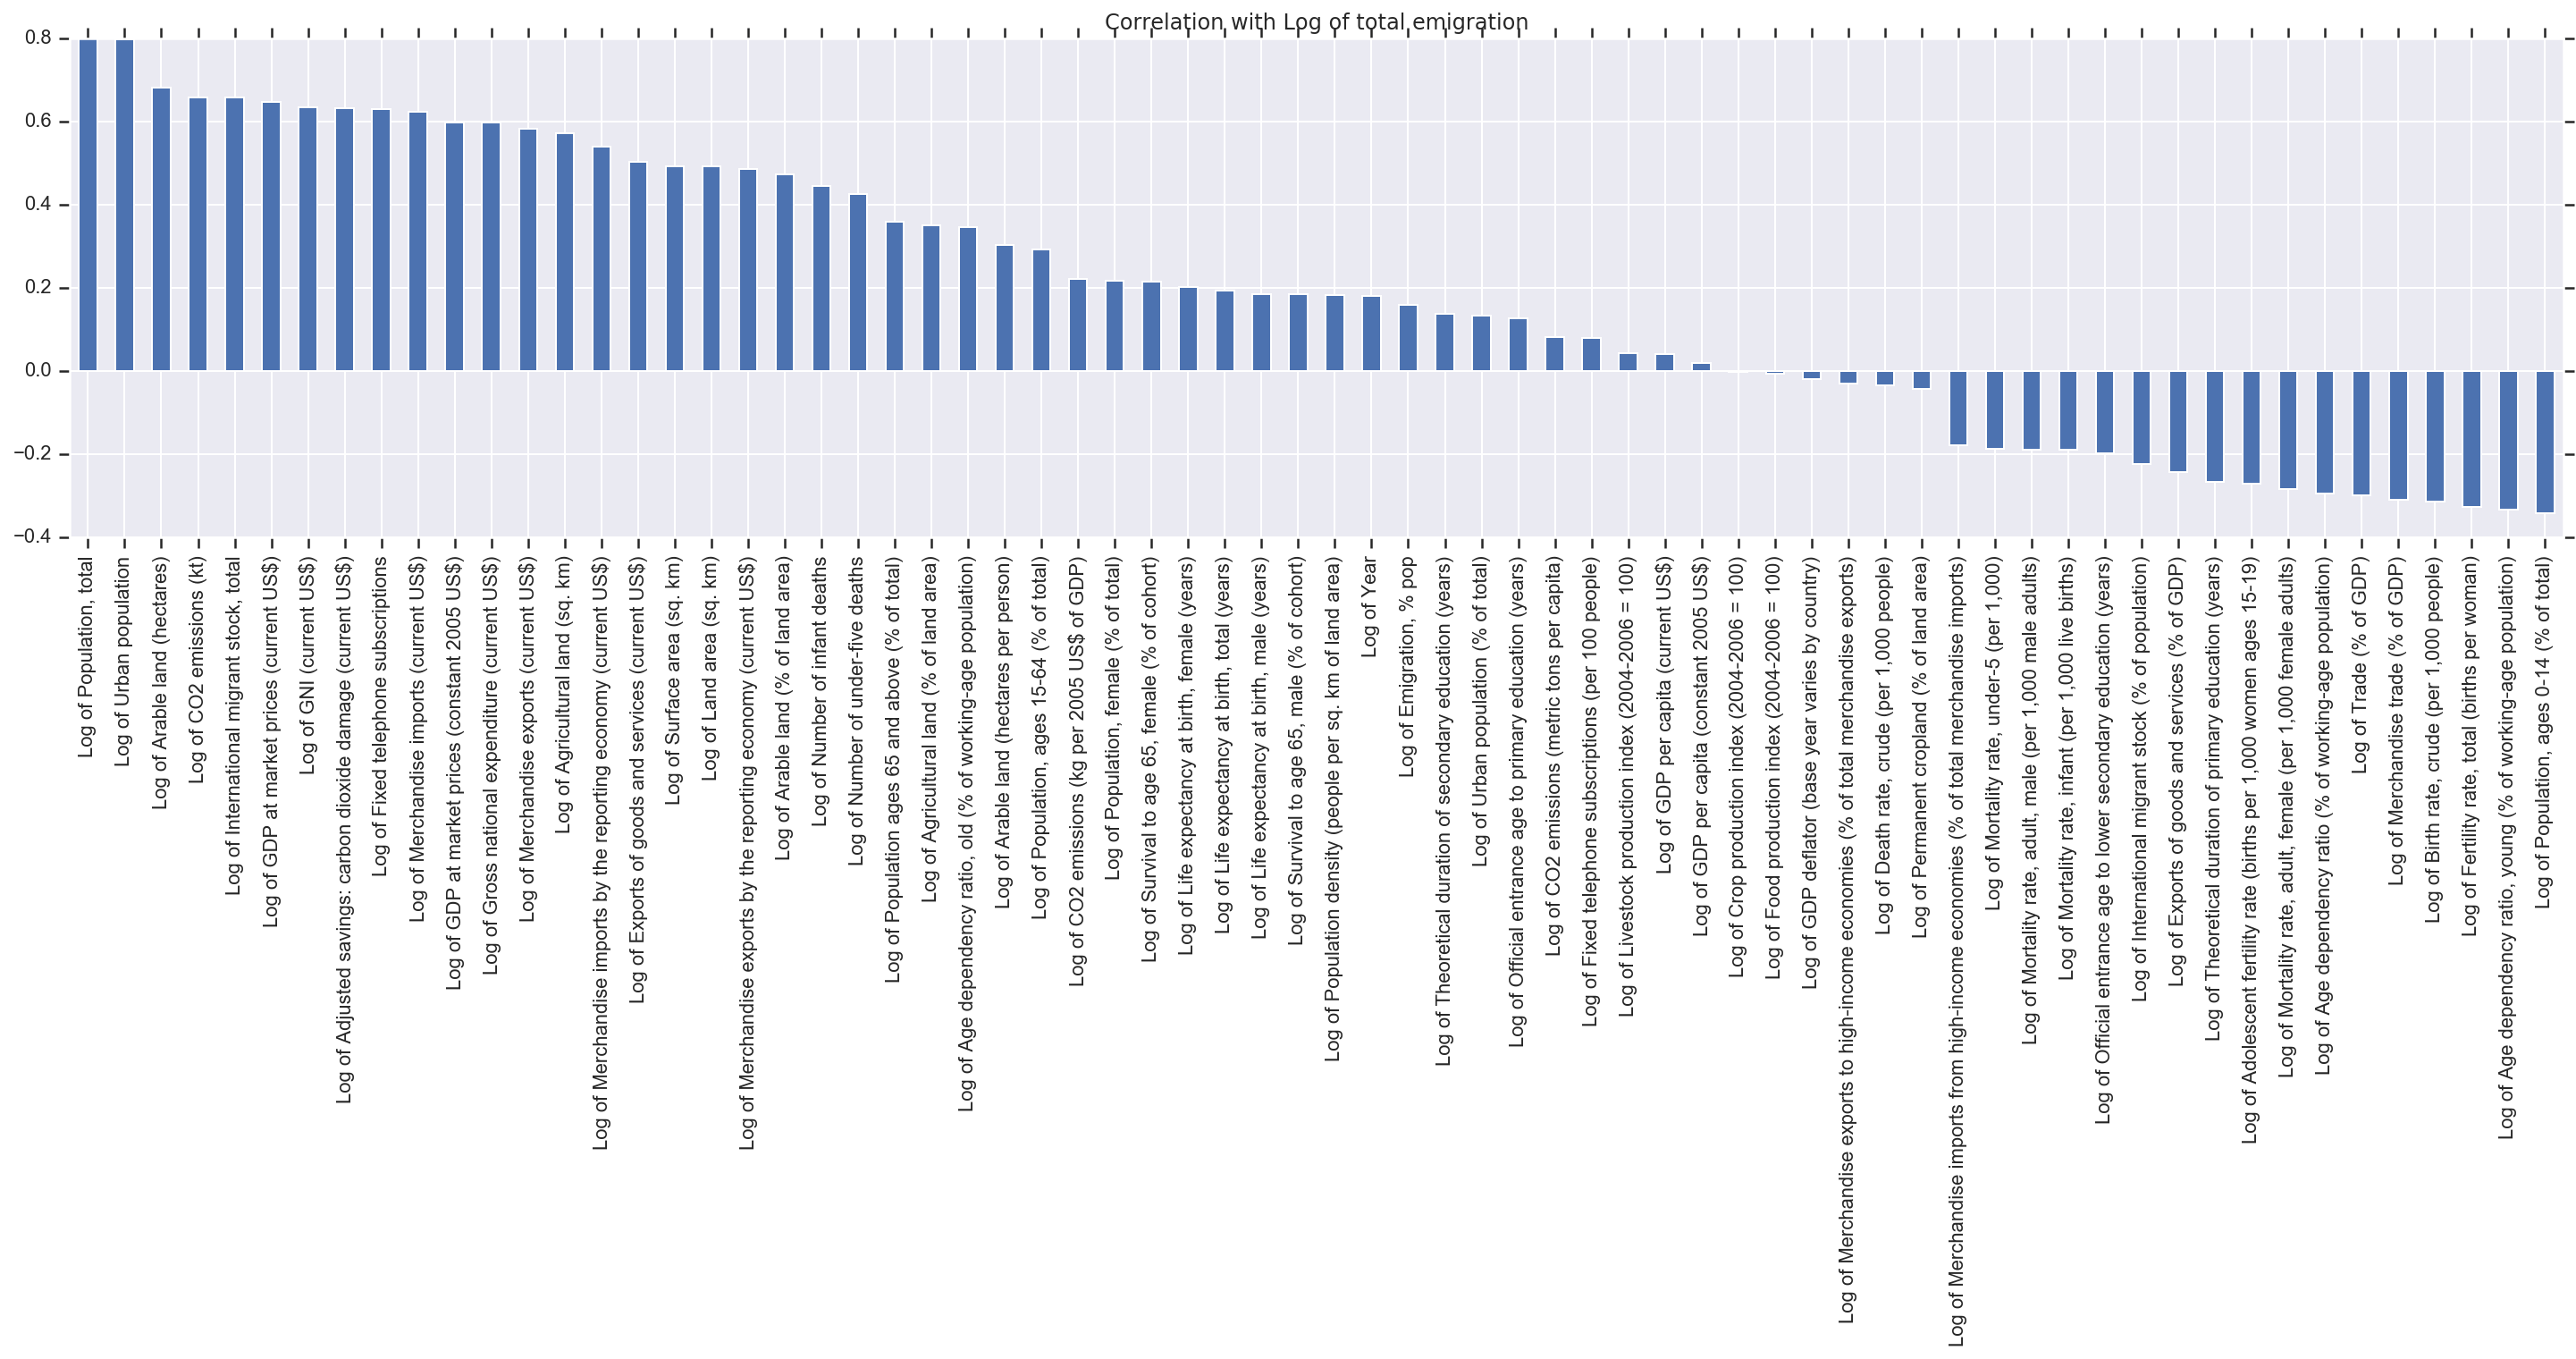

In [59]:
data_log.corr()['Log of Emigration, total'].drop('Log of Emigration, total').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with Log of total emigration')

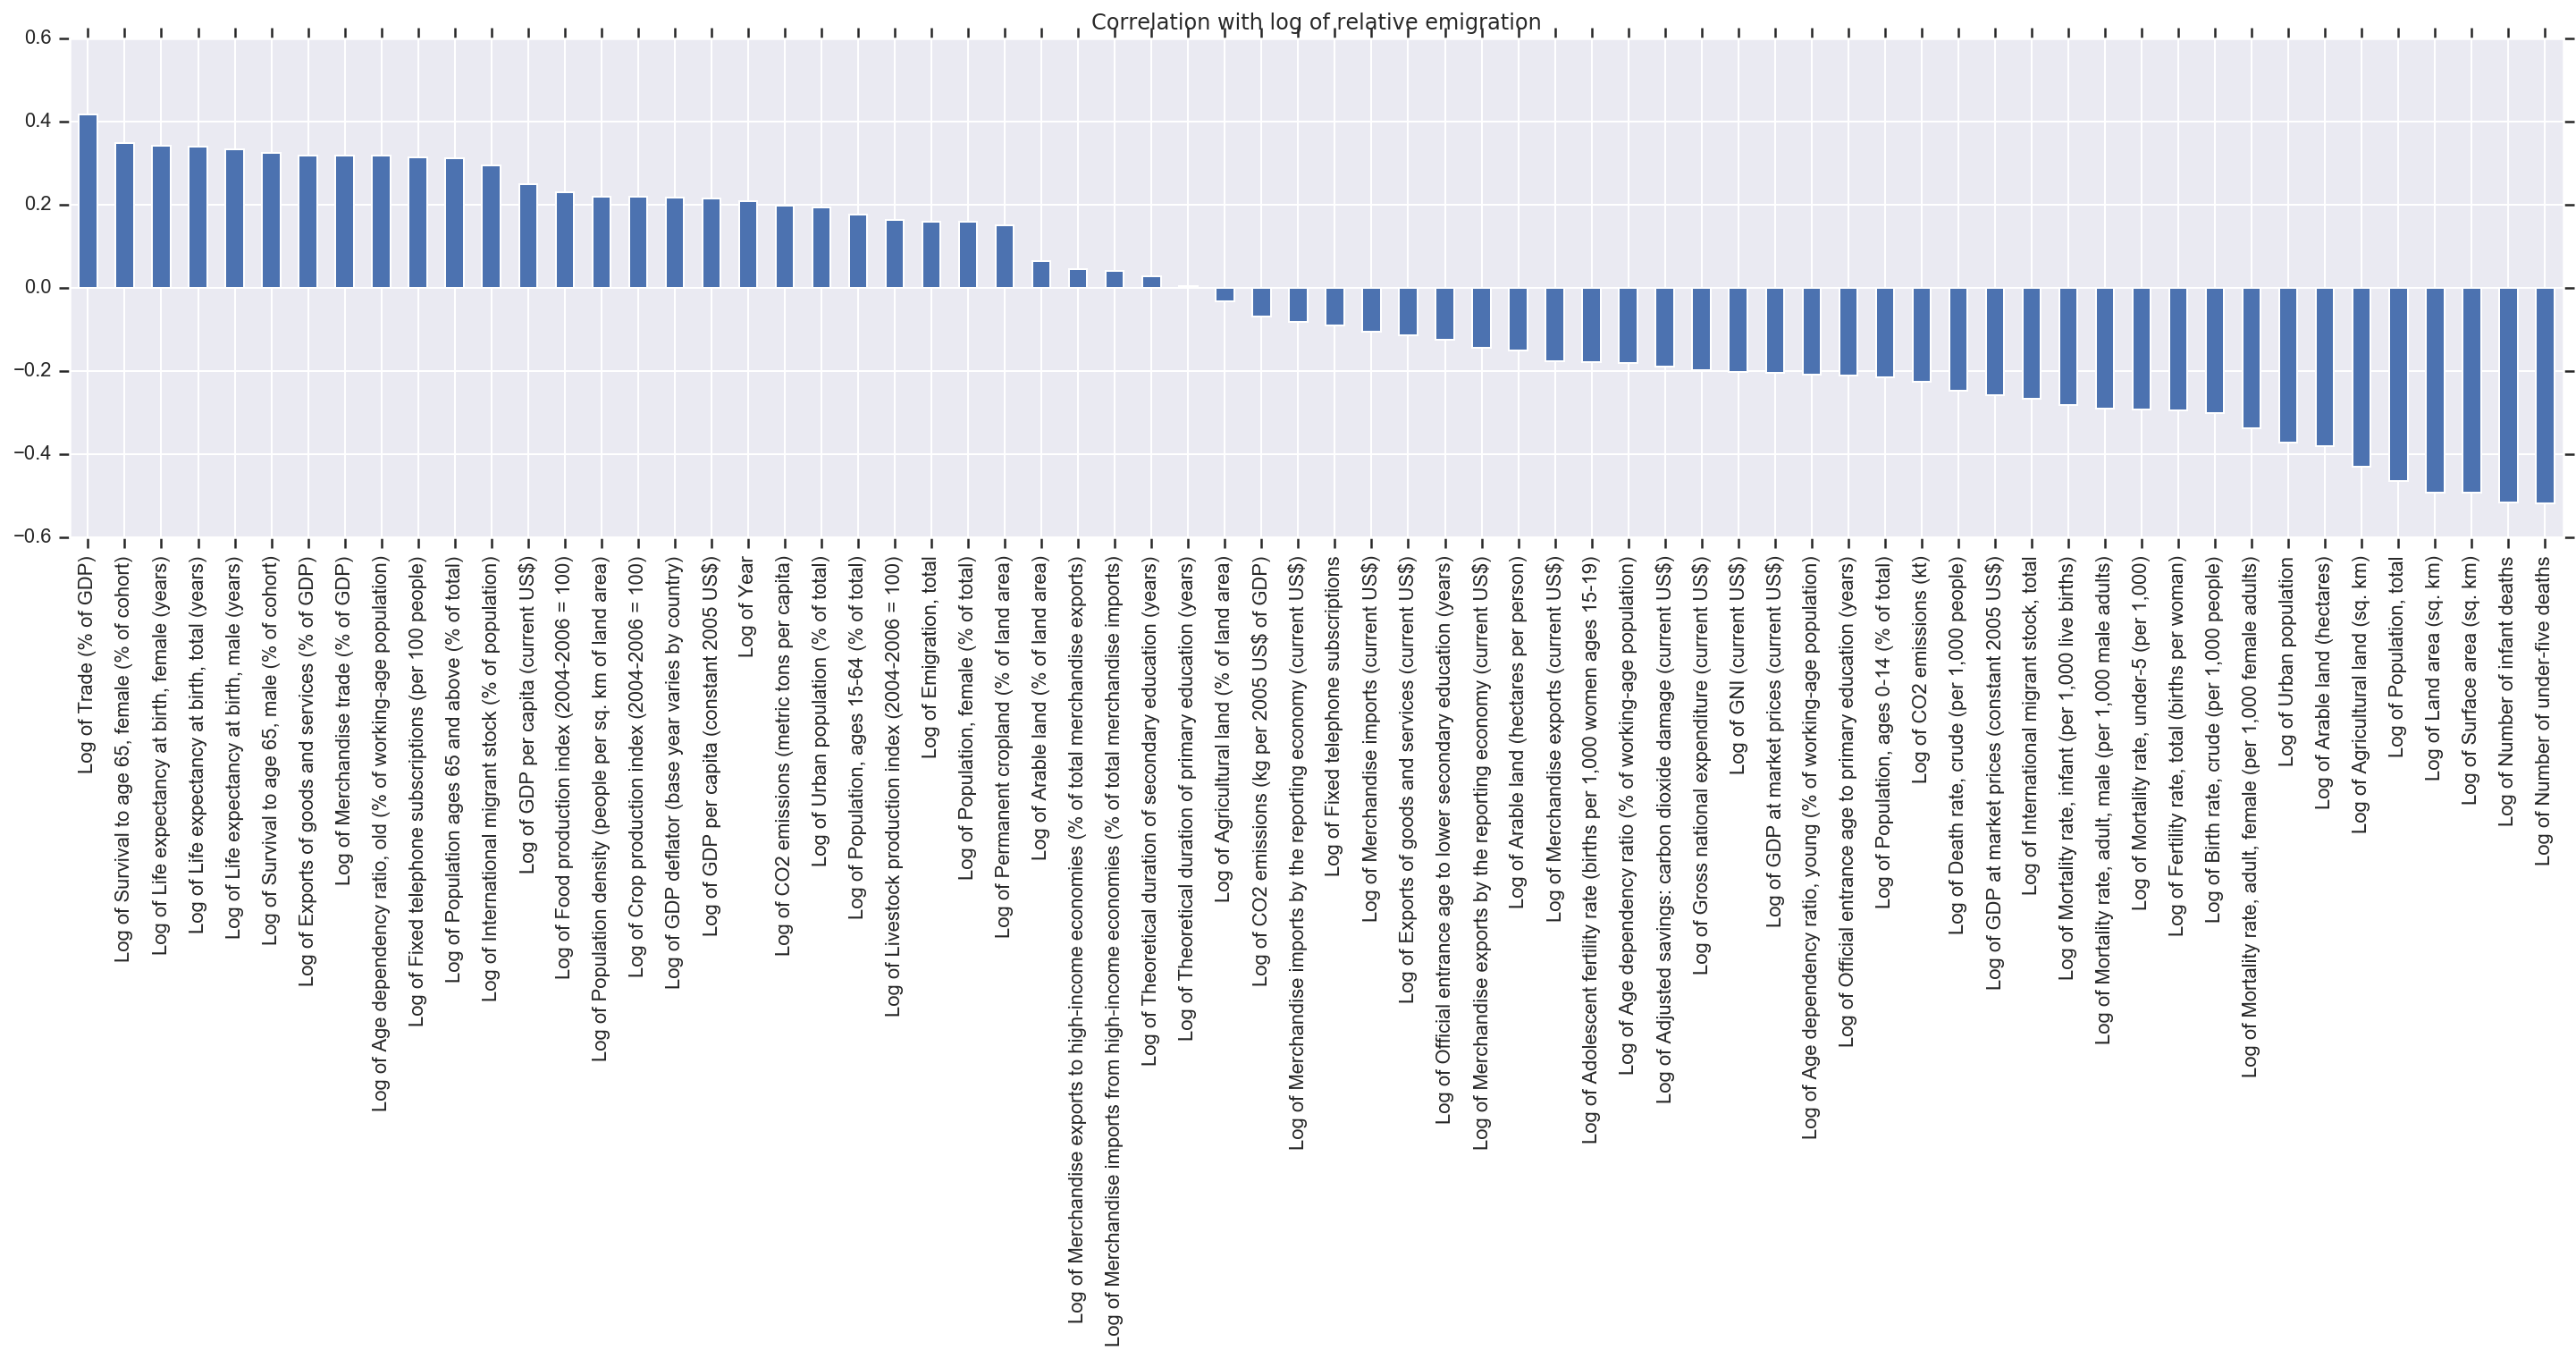

In [62]:
data_log.corr()['Log of Emigration, % pop'].drop('Log of Emigration, % pop').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with log of relative emigration')


In [408]:
data_log['Surface, size class'] = pd.cut(data_log['Log of Surface area (sq. km)'],bins=3,labels=['small','medium','large'])
            

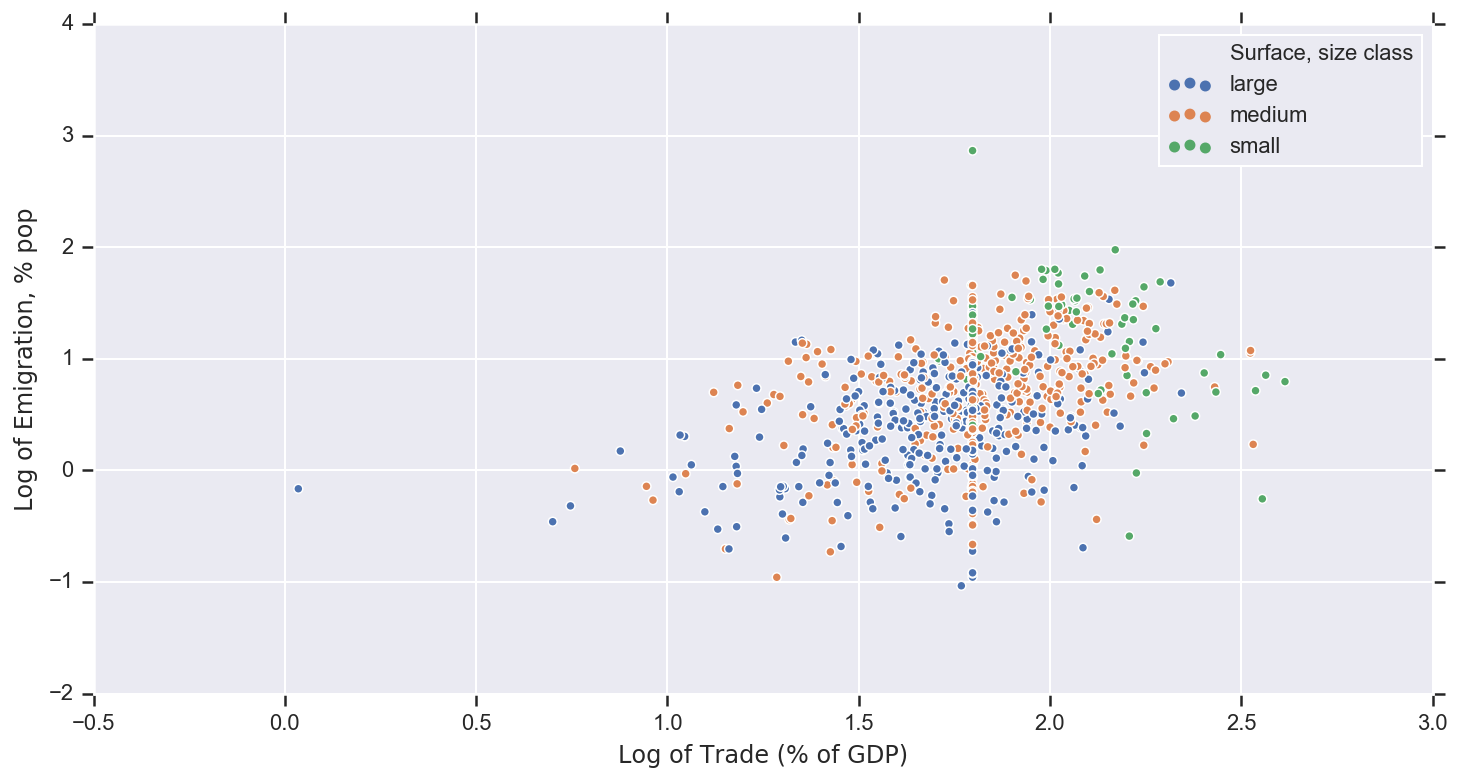

In [419]:
sns.scatterplot(data=data_log,y='Log of Emigration, % pop',x='Log of Trade (% of GDP)',hue='Surface, size class')


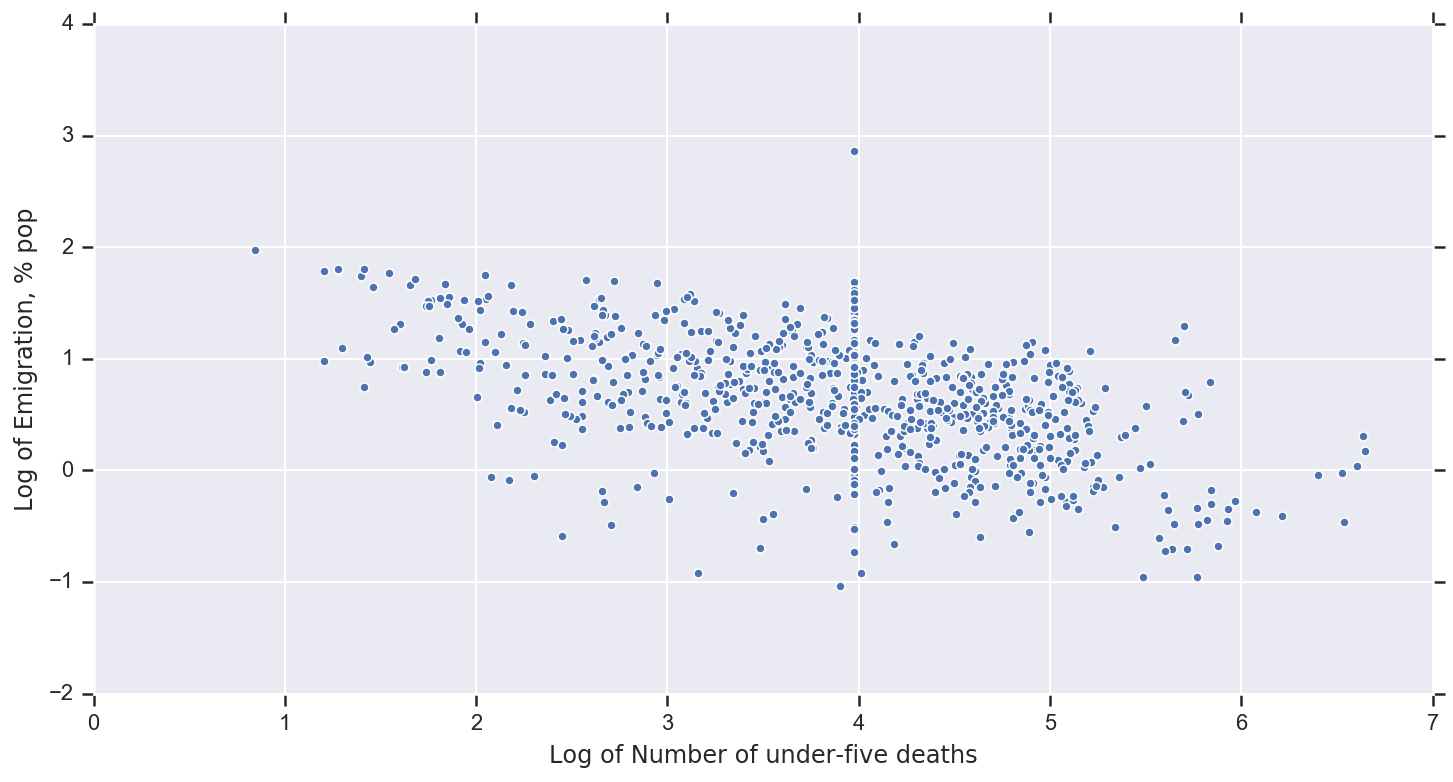

In [390]:
sns.scatterplot(data=data_log,y='Log of Emigration, % pop',x='Log of Number of under-five deaths')

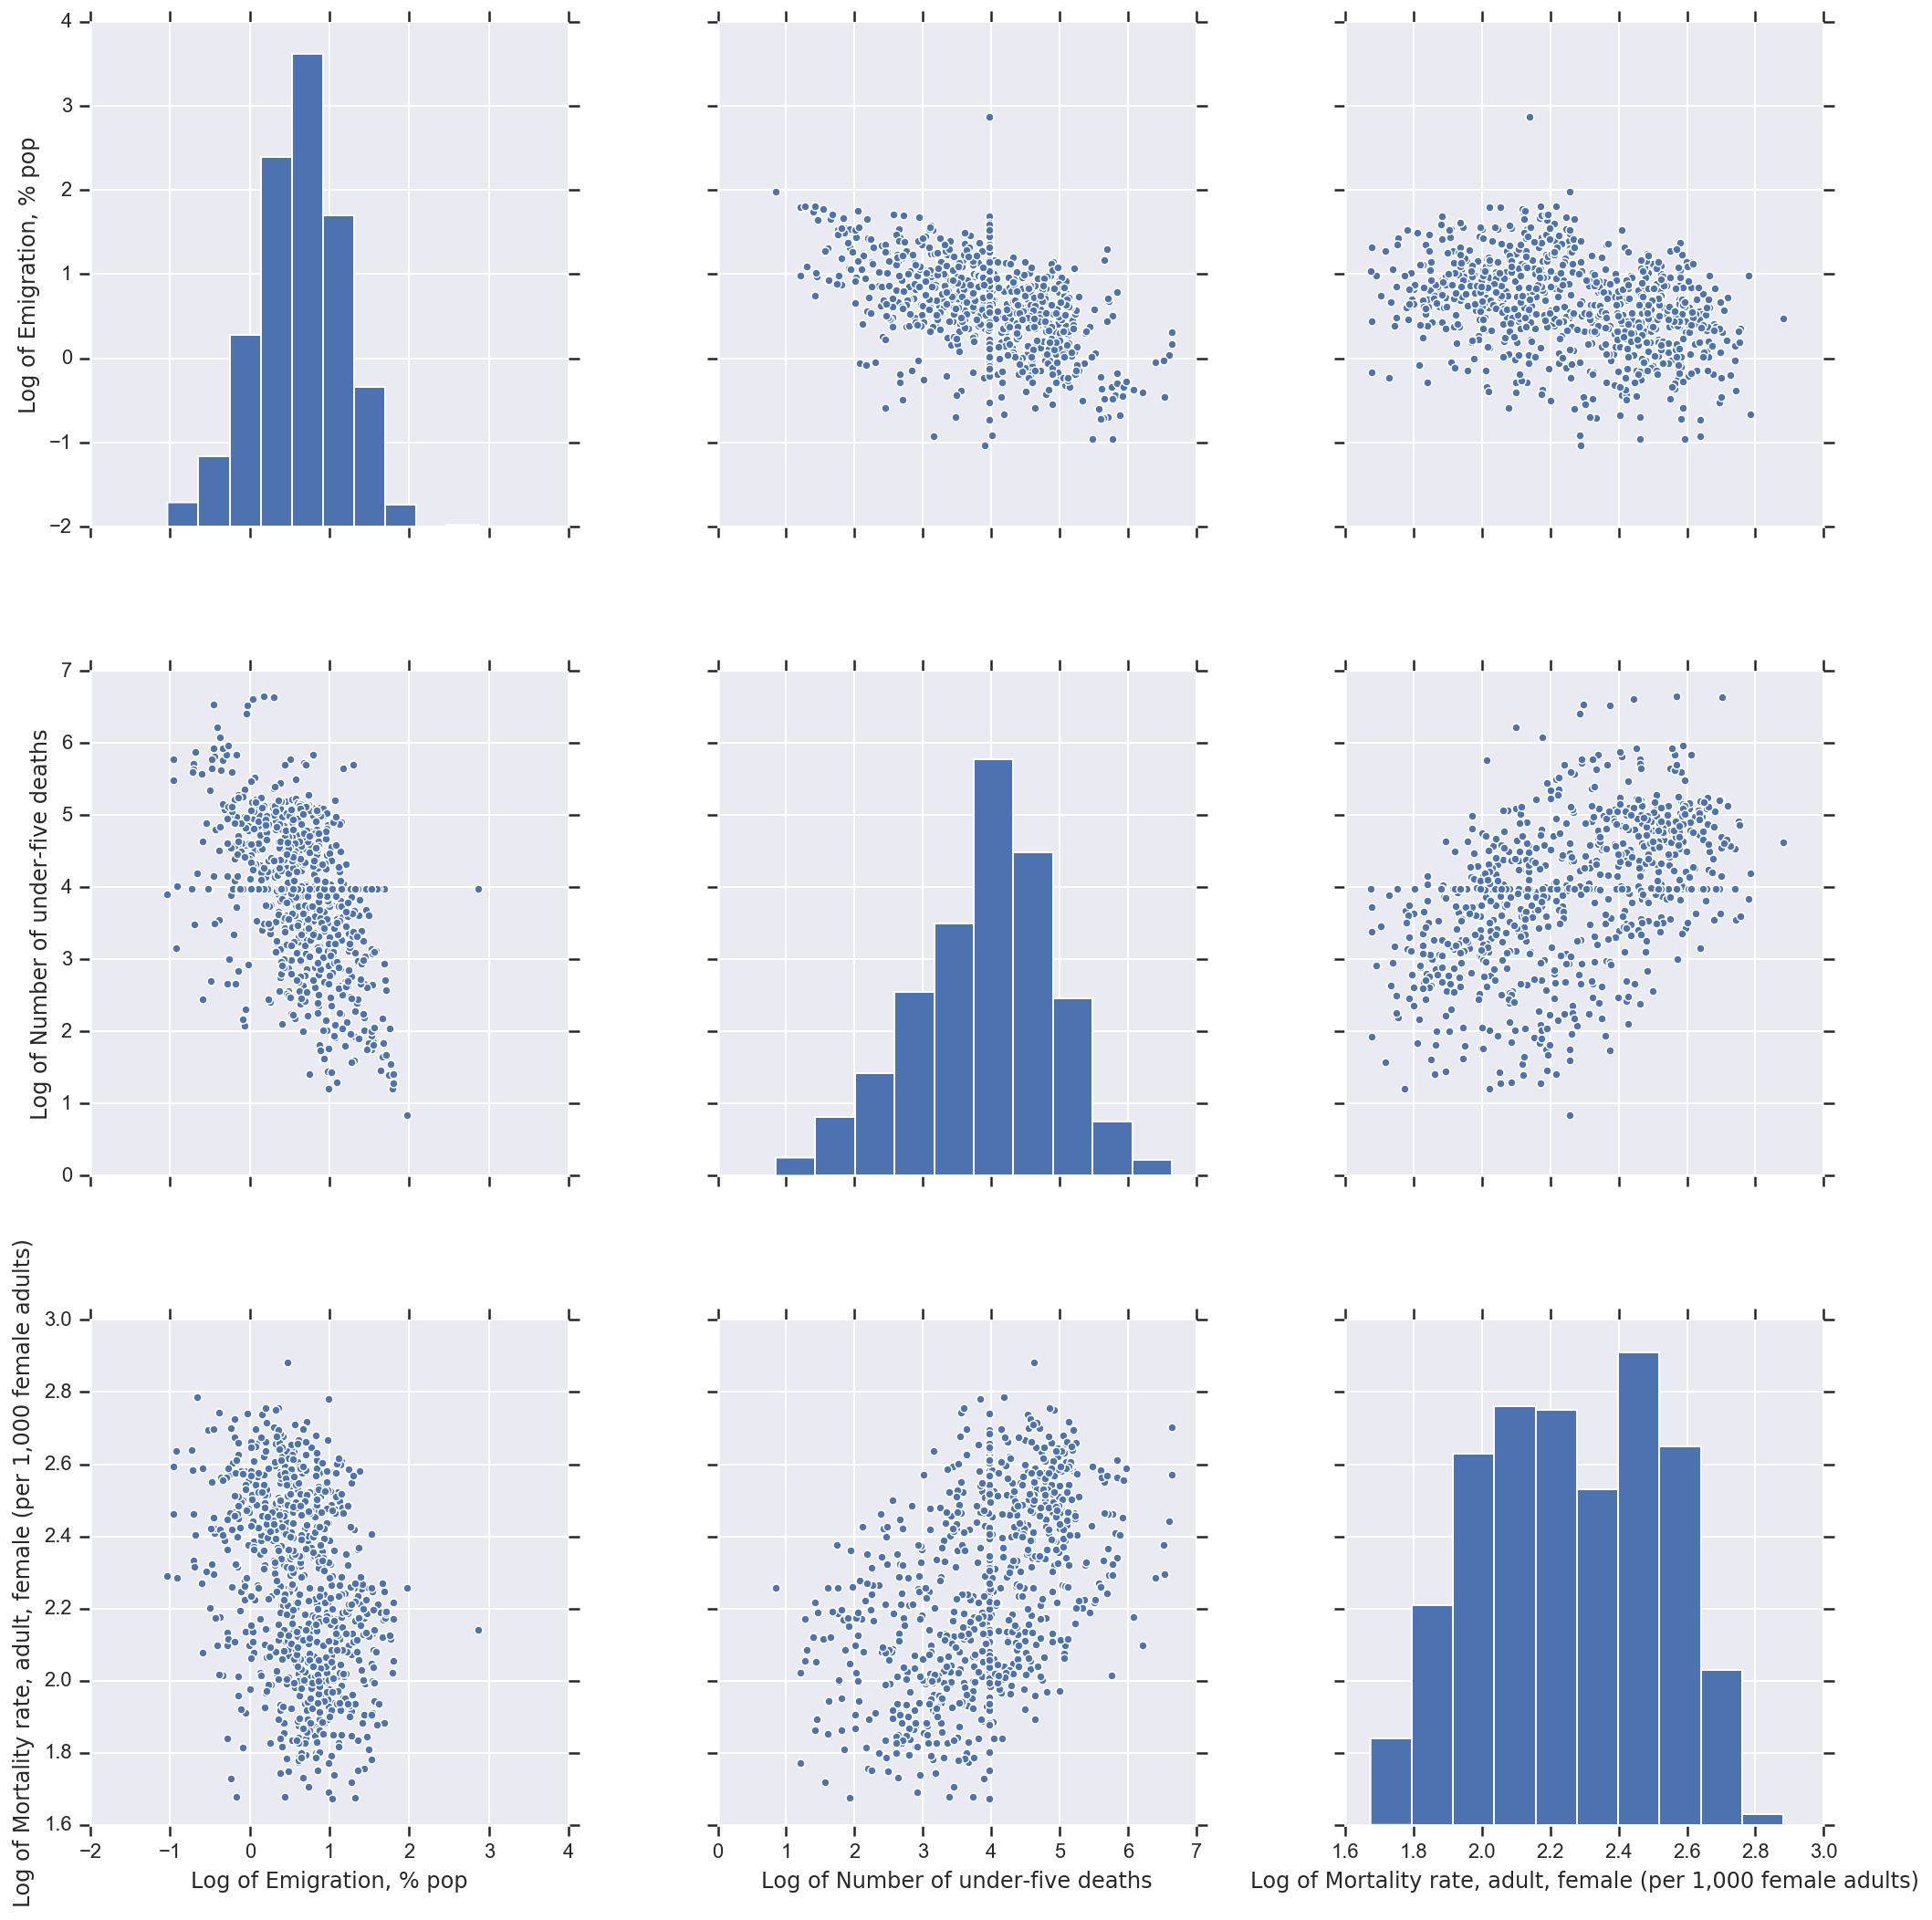

In [386]:
sns.pairplot(data_log[['Log of Emigration, % pop','Log of Number of under-five deaths','Log of Mortality rate, adult, female (per 1,000 female adults)']],height=5)


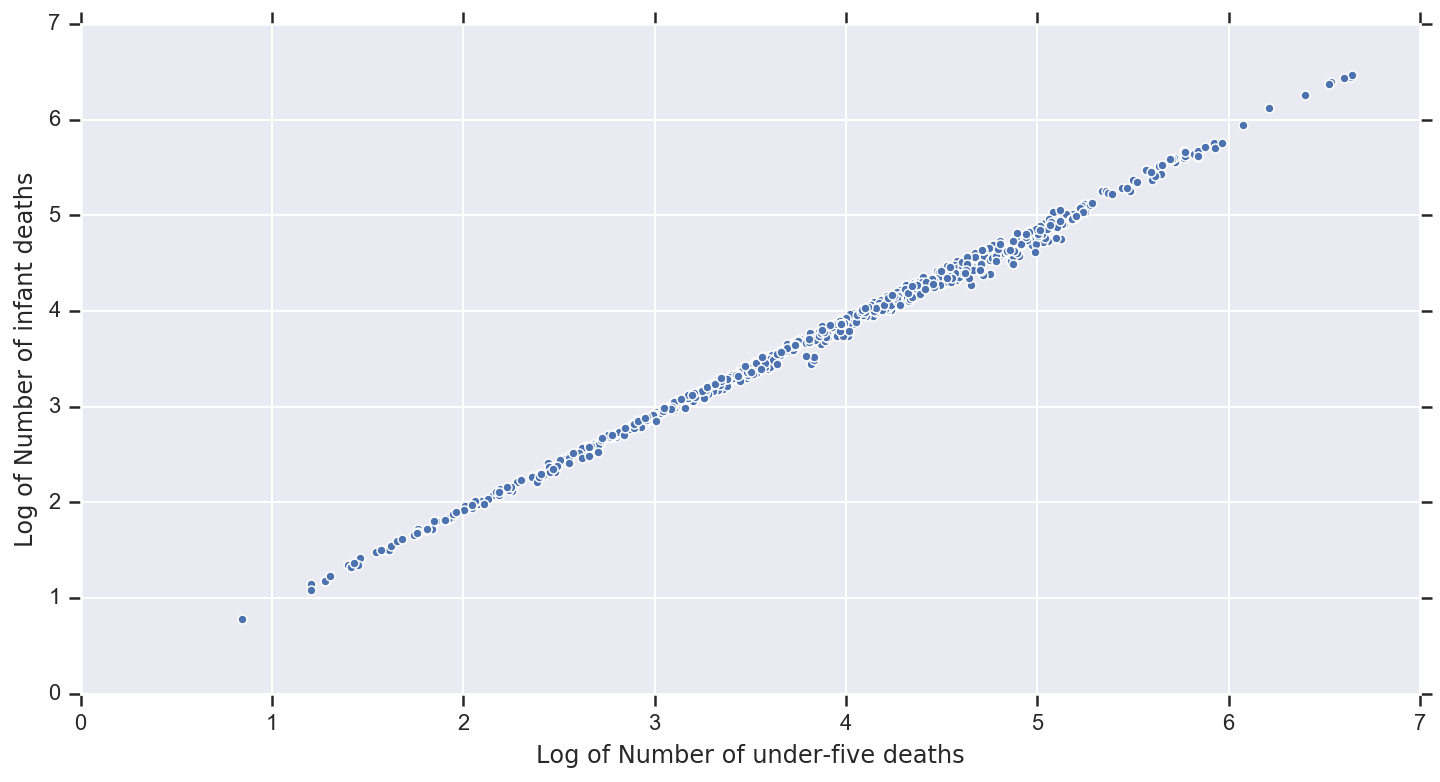

## The issue of correlation
Many indicators appear to be well correlated with one or more other indicators. Both by their definition, or because of a common causal effect. 

Effect on modeling. 
This is an issue that deserve further investigation. 
We explore the distance betweeen indicators. log. 
We use a xx metric, and a xx method. 

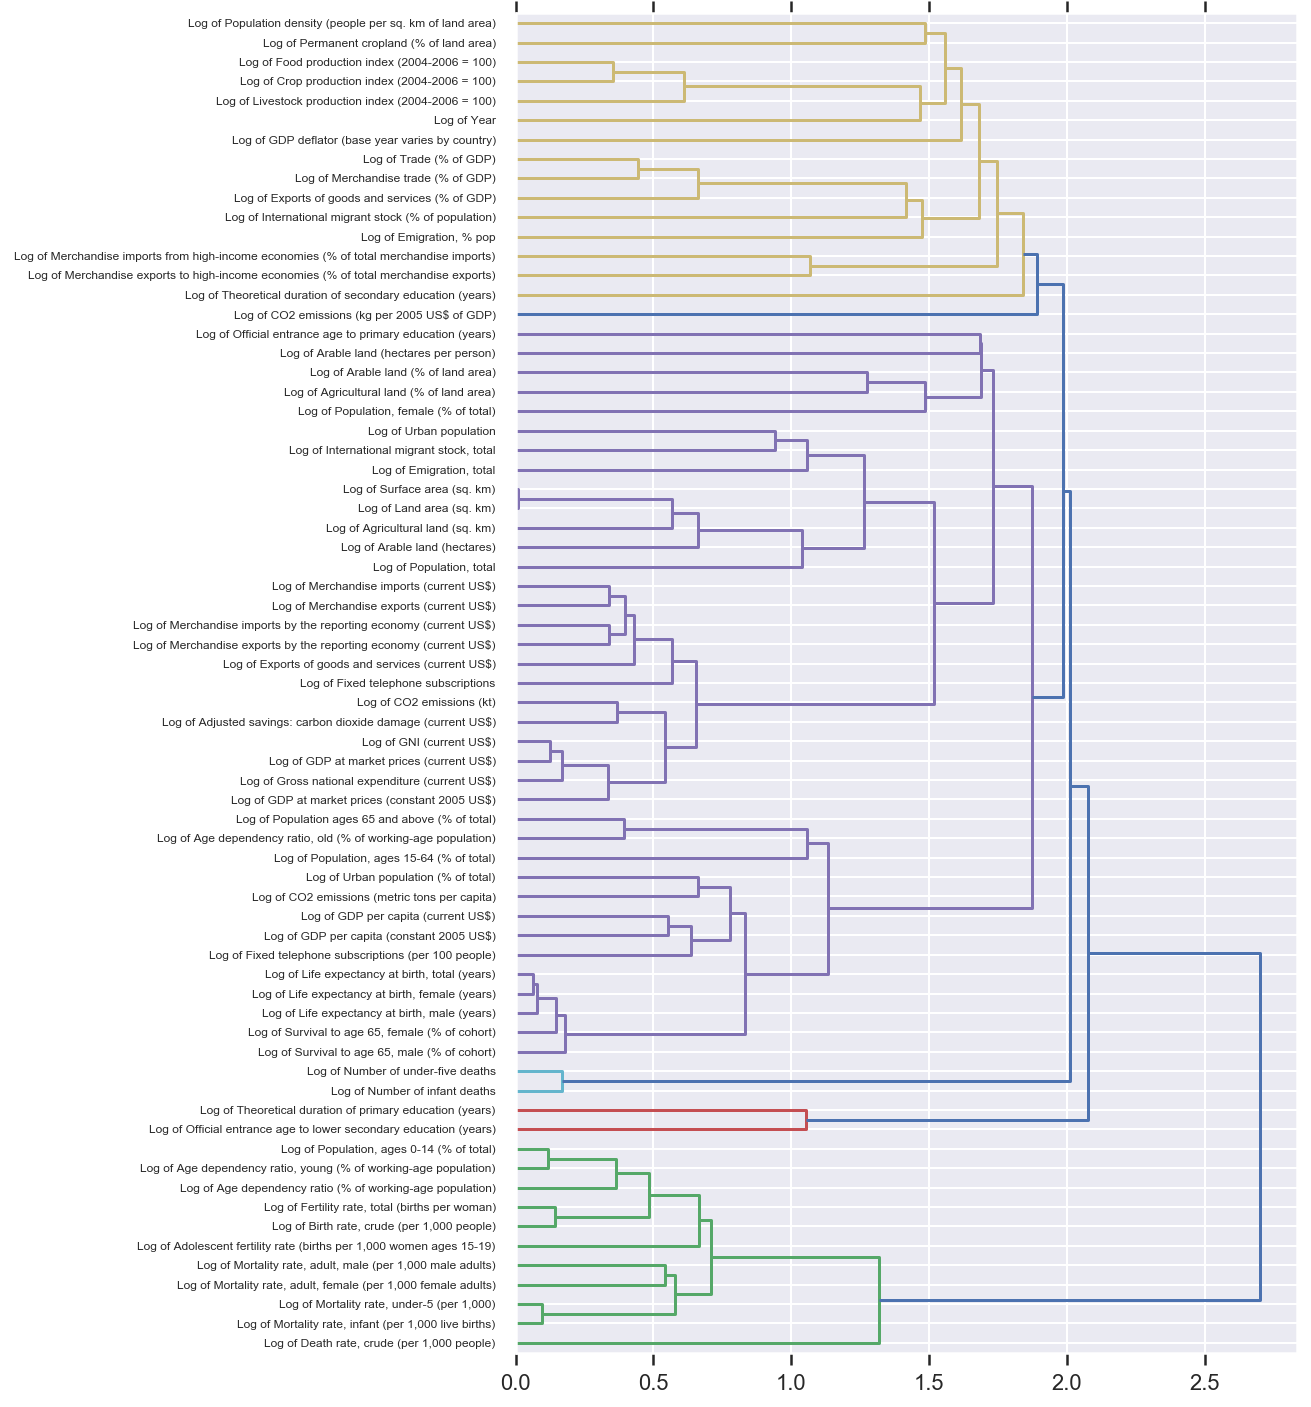

In [397]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data_log.corr(),method='single',metric='euclidean')
plt.figure(figsize=(7,12))
dn = dendrogram(Z,orientation='right',truncate_mode=None,distance_sort='descendent',labels=data_log.corr().index)

____
The graph above. 
Comments. 
This will be very important in the modeling phase. 

In [220]:
# Save data 
data_tot = data_set_cut.join(data_log,how='outer')
data_tot.to_csv('data/emigration_indicators_data.csv',index=False)